In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from os import system
from sklearn.model_selection import GridSearchCV
sns.set_style("ticks", {"xtick.major.size": 18, "ytick.major.size": 18})

In [2]:
dth = pd.read_excel('Customer Churn Data.xlsx',sheet_name='Data for DSBA')

In [4]:
dth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11260 entries, 0 to 11259
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AccountID                11260 non-null  int64  
 1   Churn                    11260 non-null  int64  
 2   Tenure                   11158 non-null  object 
 3   City_Tier                11148 non-null  float64
 4   CC_Contacted_LY          11158 non-null  float64
 5   Payment                  11151 non-null  object 
 6   Gender                   11152 non-null  object 
 7   Service_Score            11162 non-null  float64
 8   Account_user_count       11148 non-null  object 
 9   account_segment          11163 non-null  object 
 10  CC_Agent_Score           11144 non-null  float64
 11  Marital_Status           11048 non-null  object 
 12  rev_per_month            11158 non-null  object 
 13  Complain_ly              10903 non-null  float64
 14  rev_growth_yoy        

In [5]:
dth.head()

,AccountID,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device
0,20000,1,4,3.0,6.0,Debit Card,Female,3.0,3,Super,2.0,Single,9,1.0,11,1,5,159.93,Mobile
1,20001,1,0,1.0,8.0,UPI,Male,3.0,4,Regular Plus,3.0,Single,7,1.0,15,0,0,120.9,Mobile
2,20002,1,0,1.0,30.0,Debit Card,Male,2.0,4,Regular Plus,3.0,Single,6,1.0,14,0,3,NaN,Mobile
3,20003,1,0,3.0,15.0,Debit Card,Male,2.0,4,Super,5.0,Single,8,0.0,23,0,3,134.07,Mobile
4,20004,1,0,1.0,12.0,Credit Card,Male,2.0,3,Regular Plus,5.0,Single,3,0.0,11,1,3,129.6,Mobile


In [6]:
dth.cashback.mode()[0]

155.62

In [7]:
dth.isnull().sum()

AccountID                    0
Churn                        0
Tenure                     102
City_Tier                  112
CC_Contacted_LY            102
Payment                    109
Gender                     108
Service_Score               98
Account_user_count         112
account_segment             97
CC_Agent_Score             116
Marital_Status             212
rev_per_month              102
Complain_ly                357
rev_growth_yoy               0
coupon_used_for_payment      0
Day_Since_CC_connect       357
cashback                   471
Login_device               221
dtype: int64

In [3]:
dth = dth.drop('AccountID',axis=1)

In [4]:
ds_cat_stats = pd.DataFrame(columns = ['column', 'values', 'values_count_incna', 'values_count_nona', 
                                       'num_miss', 'pct_miss'])
tmp = pd.DataFrame()

for c in dth.columns:
    tmp['column'] = [c]
    tmp['values'] = [dth[c].unique()]
    tmp['values_count_incna'] = len(list(dth[c].unique()))
    tmp['values_count_nona'] = int(dth[c].nunique())
    tmp['num_miss'] = dth[c].isnull().sum()
    tmp['pct_miss'] = (dth[c].isnull().sum()/ len(dth)).round(3)*100
    ds_cat_stats = ds_cat_stats.append(tmp)
    
ds_cat_stats

,column,values,values_count_incna,values_count_nona,num_miss,pct_miss
0,Churn,"[1, 0]",2,2,0,0.0
0,Tenure,"[4, 0, 2, 13, 11, #, 9, 99, 19, 20, 14, 8, 26,...",39,38,102,0.9
0,City_Tier,"[3.0, 1.0, nan, 2.0]",4,3,112,1.0
0,CC_Contacted_LY,"[6.0, 8.0, 30.0, 15.0, 12.0, 22.0, 11.0, 9.0, ...",45,44,102,0.9
0,Payment,"[Debit Card, UPI, Credit Card, Cash on Deliver...",6,5,109,1.0
0,Gender,"[Female, Male, F, nan, M]",5,4,108,1.0
0,Service_Score,"[3.0, 2.0, 1.0, nan, 0.0, 4.0, 5.0]",7,6,98,0.9
0,Account_user_count,"[3, 4, nan, 5, 2, @, 1, 6]",8,7,112,1.0
0,account_segment,"[Super, Regular Plus, Regular, HNI, Regular +,...",8,7,97,0.9
0,CC_Agent_Score,"[2.0, 3.0, 5.0, 4.0, nan, 1.0]",6,5,116,1.0


In [10]:
dth.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Churn,11260,NaN,NaN,NaN,0.168384,0.374223,0,0,0,0,1
Tenure,11158,38,1,1351,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City_Tier,11148,NaN,NaN,NaN,1.65393,0.915015,1,1,1,3,3
CC_Contacted_LY,11158,NaN,NaN,NaN,17.8671,8.85327,4,11,16,23,132
Payment,11151,5,Debit Card,4587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,11152,4,Male,6328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Service_Score,11162,NaN,NaN,NaN,2.90253,0.725584,0,2,3,3,5
Account_user_count,11148,7,4,4569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
account_segment,11163,7,Super,4062,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC_Agent_Score,11144,NaN,NaN,NaN,3.06649,1.37977,1,2,3,4,5


In [11]:
dth.cashback.mean

<bound method Series.mean of 0        159.93
1         120.9
2           NaN
3        134.07
4         129.6
          ...  
11255    153.71
11256    226.91
11257    191.42
11258     179.9
11259    175.04
Name: cashback, Length: 11260, dtype: object>

In [12]:
dth.duplicated().sum()

259

In [5]:
dth.drop_duplicates(inplace=True)

In [6]:
dth.Tenure.fillna(dth.Tenure.mode()[0],inplace=True)
dth.Tenure.replace(to_replace = '#', value =dth.Tenure.mode()[0],inplace=True)

In [7]:
dth.City_Tier.fillna(dth.City_Tier.mode()[0],inplace=True)
dth.CC_Contacted_LY.fillna(dth.CC_Contacted_LY.mode()[0],inplace=True)
dth.Payment.fillna(dth.Payment.mode()[0],inplace=True)
dth.Gender.replace(to_replace = 'Female', value ='F',inplace=True)
dth.Gender.replace(to_replace = 'Male', value ='M',inplace=True)
dth.Gender.fillna(dth.Gender.mode()[0],inplace=True)
dth.Service_Score.fillna(dth.Service_Score.mode()[0],inplace=True)
dth.Account_user_count.replace(to_replace = '@', value =np.nan,inplace=True)
dth.Account_user_count.fillna(dth.Account_user_count.mode()[0],inplace=True)
dth.account_segment.fillna(dth.account_segment.mode()[0],inplace=True)
dth.CC_Agent_Score.fillna(dth.CC_Agent_Score.mode()[0],inplace=True)
dth.Marital_Status.fillna(dth.Marital_Status.mode()[0],inplace=True)
dth.Complain_ly.fillna(dth.Complain_ly.mode()[0],inplace=True)
dth.coupon_used_for_payment.replace(to_replace = '#', value =dth.coupon_used_for_payment.mode()[0],inplace=True)
dth.coupon_used_for_payment.replace(to_replace = '$', value =dth.coupon_used_for_payment.mode()[0],inplace=True)
dth.coupon_used_for_payment.replace(to_replace = '*', value =dth.coupon_used_for_payment.mode()[0],inplace=True)
dth.coupon_used_for_payment.fillna(dth.coupon_used_for_payment.mode()[0],inplace=True)
dth.Day_Since_CC_connect.replace(to_replace = '$', value =dth.Day_Since_CC_connect.mode()[0],inplace=True)
dth.Day_Since_CC_connect.fillna(dth.Day_Since_CC_connect.mode()[0],inplace=True)
dth.cashback.fillna(dth.cashback.mode()[0],inplace=True)
dth.Login_device.replace(to_replace = '&&&&', value =dth.Login_device.mode()[0],inplace=True)
dth.Login_device.fillna(dth.Login_device.mode()[0],inplace=True)
dth.cashback.replace(to_replace = '$', value =dth.cashback.mode()[0],inplace=True)


In [8]:
dth.rev_per_month.replace(to_replace = '+', value =dth.rev_per_month.mode()[0],inplace=True)
dth.rev_per_month.fillna(dth.rev_per_month.mode()[0],inplace=True)
dth.rev_growth_yoy.replace(to_replace = '$', value =dth.rev_growth_yoy.mode()[0],inplace=True)
dth.rev_growth_yoy.fillna(dth.rev_growth_yoy.mode()[0],inplace=True)

In [9]:
dth.Churn.value_counts(normalize=True)

0    0.831652
1    0.168348
Name: Churn, dtype: float64

In [10]:
dth.cashback.astype('int')

0        159
1        120
2        155
3        134
4        129
        ... 
11255    153
11256    226
11257    191
11258    179
11259    175
Name: cashback, Length: 11001, dtype: int32

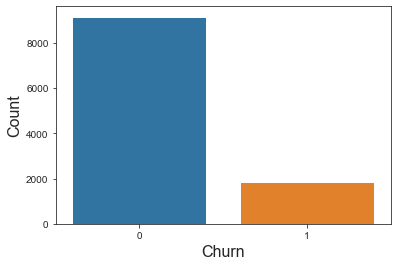

In [95]:
fig, ax = plt.subplots()
sns.countplot(x=dth['Churn'])
ax.set_xlabel('Churn', fontsize=16)
ax.set_ylabel('Count', fontsize=16)

plt.show()

## Univariate

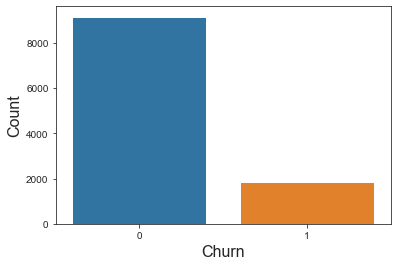

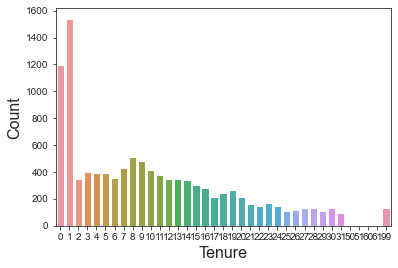

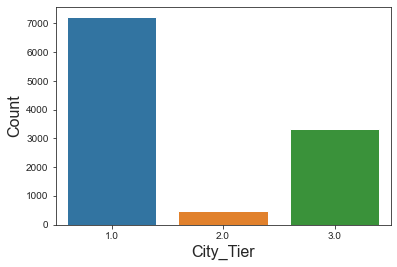

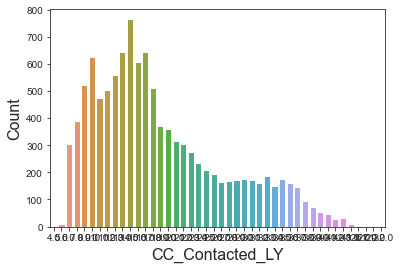

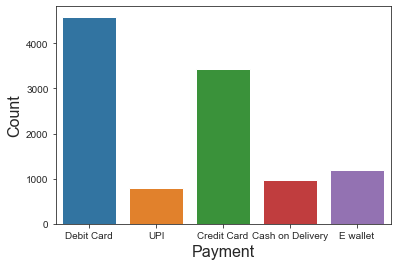

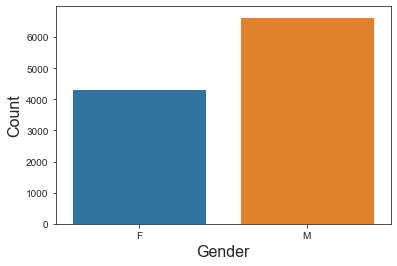

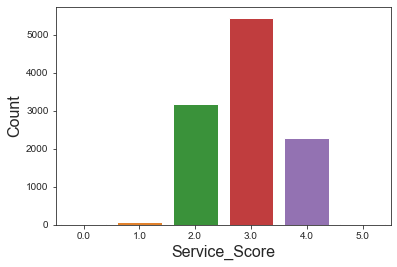

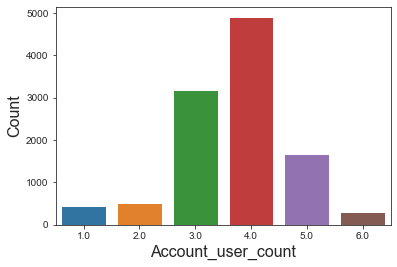

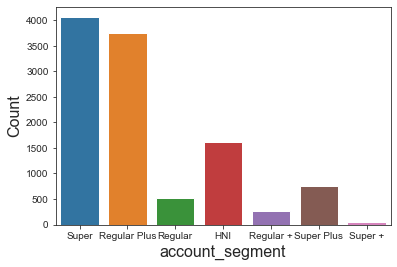

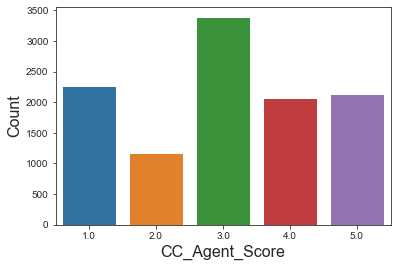

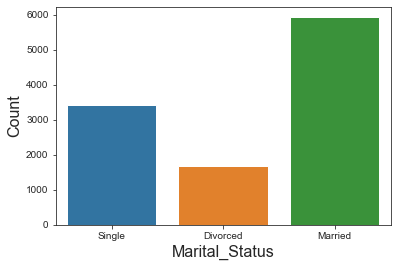

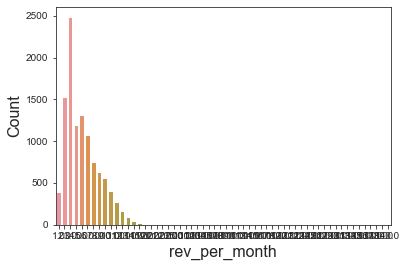

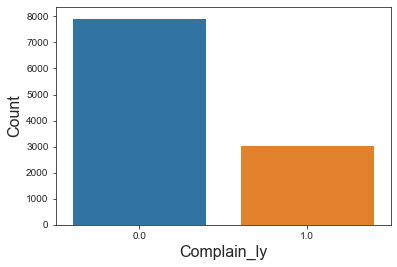

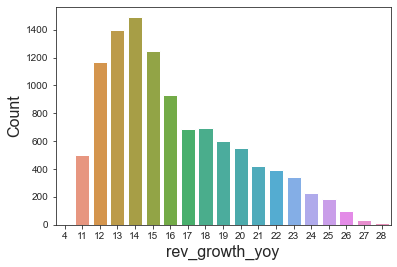

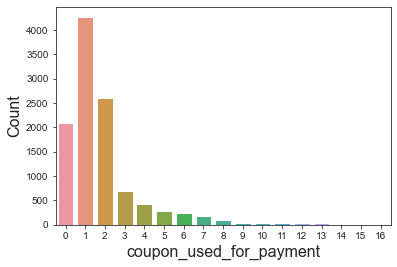

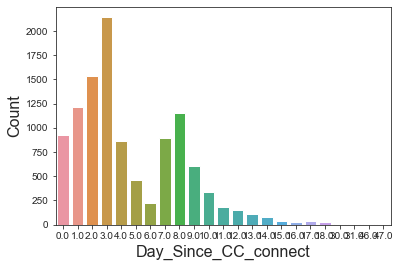

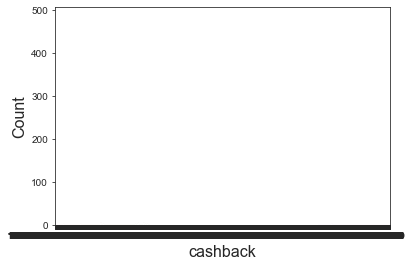

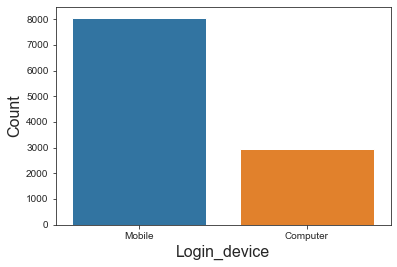

In [97]:
for col in dth.columns:
    fig, ax = plt.subplots()
    sns.countplot(x=dth[col])
    ax.set_xlabel(col, fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    plt.show()

In [66]:
for col in dth.columns:
    print(dth[col].value_counts(normalize=True))

0    0.831652
1    0.168348
Name: Churn, dtype: float64
1     0.139987
0     0.108899
8     0.046359
9     0.044087
7     0.039269
10    0.037451
3     0.036269
5     0.035815
4     0.035724
11    0.034179
6     0.032542
13    0.031724
12    0.031724
2     0.031361
14    0.030724
15    0.027543
16    0.025725
19    0.024271
18    0.022453
17    0.019271
20    0.019180
23    0.015090
21    0.014908
22    0.013453
24    0.013090
30    0.012363
28    0.012090
99    0.011908
27    0.011817
26    0.010999
25    0.010181
29    0.010181
31    0.008636
50    0.000182
51    0.000182
60    0.000182
61    0.000182
Name: Tenure, dtype: float64
1.0    0.655304
3.0    0.303245
2.0    0.041451
Name: City_Tier, dtype: float64
14.0     0.069539
13.0     0.058540
16.0     0.058540
9.0      0.056813
15.0     0.055177
12.0     0.050904
8.0      0.047632
17.0     0.046632
11.0     0.045905
10.0     0.043178
7.0      0.035270
18.0     0.033815
19.0     0.032724
20.0     0.028634
21.0     0.027816
6.0      0

Text(0, 0.5, 'count')

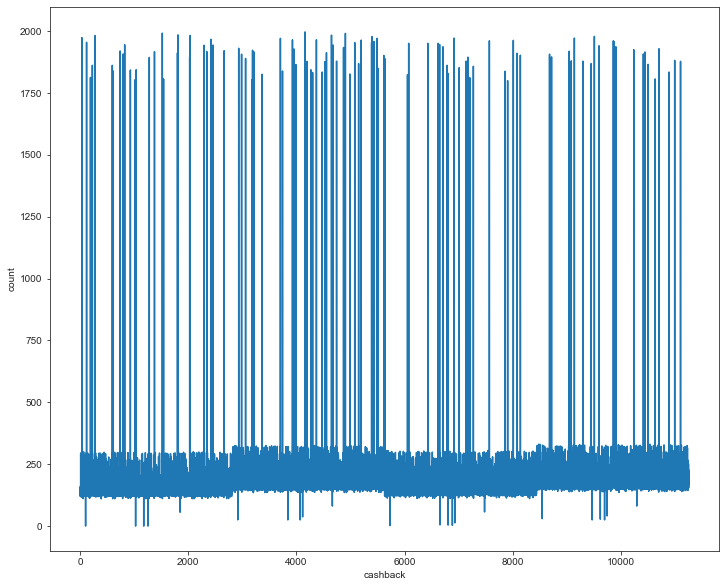

In [81]:
dth.cashback.plot(figsize=(12,10))
plt.xlabel('cashback')
plt.ylabel('count')

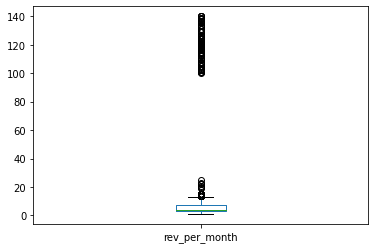

In [74]:
dth.rev_per_month.plot(kind='box')

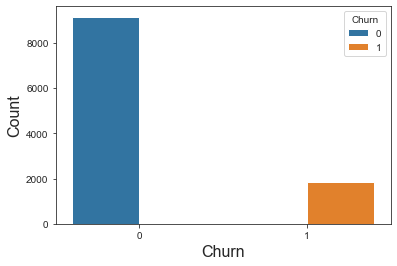

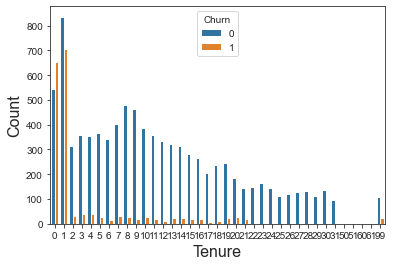

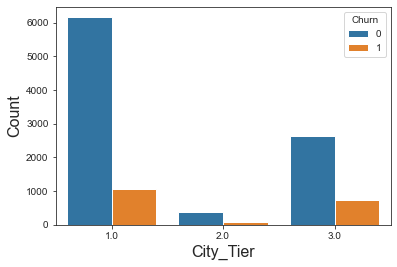

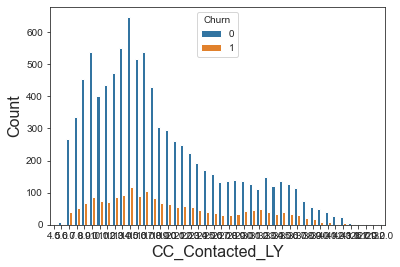

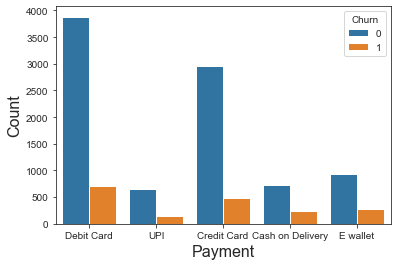

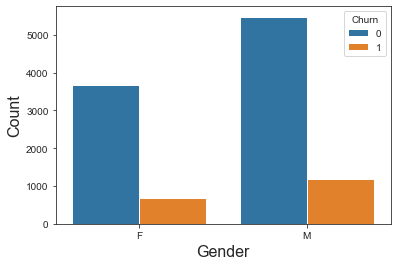

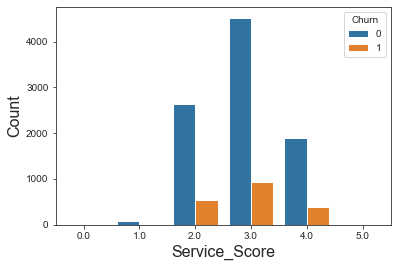

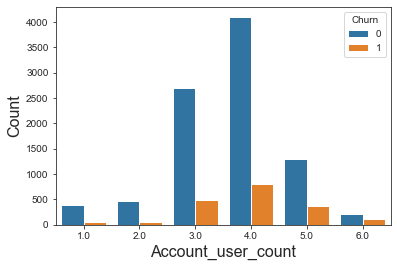

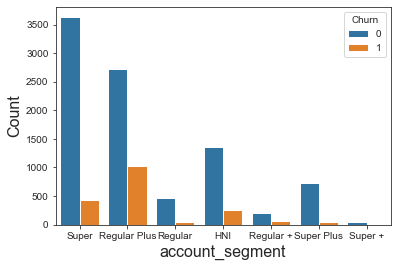

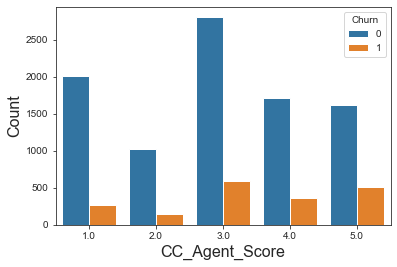

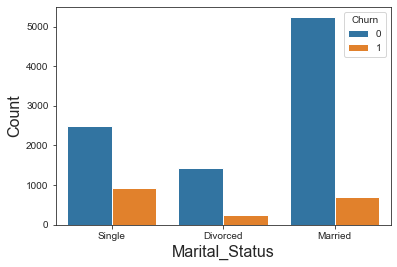

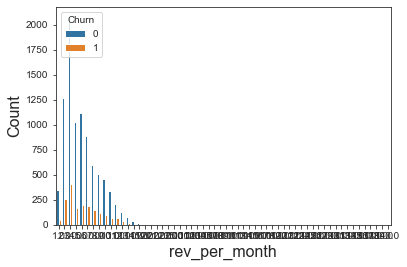

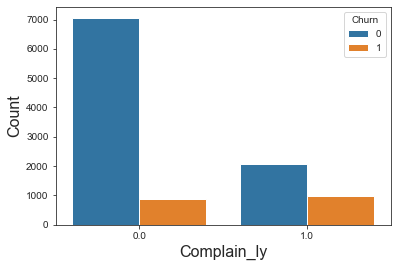

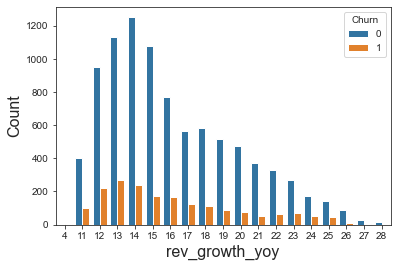

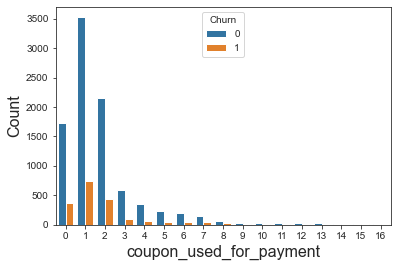

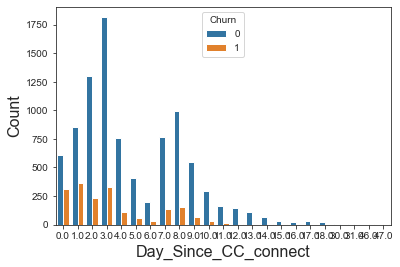

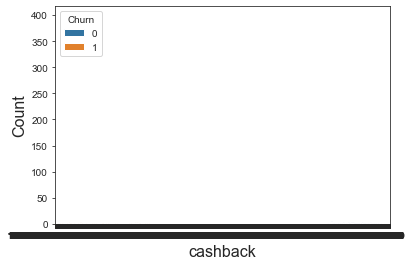

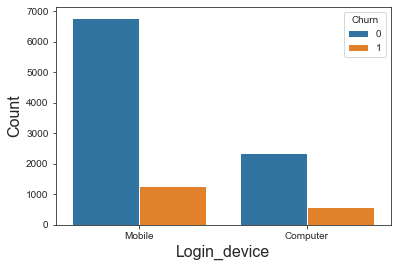

In [99]:
for col in dth.columns:
    fig, ax = plt.subplots()
    sns.countplot(x=dth[col],hue=dth.Churn)
    ax.set_xlabel(col, fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    plt.show()

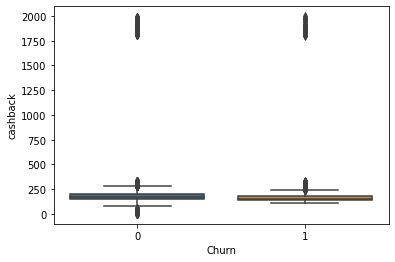

In [19]:
sns.boxplot(y=dth.cashback,x=dth.Churn)

In [9]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [10]:
lr,ur = remove_outlier(dth.cashback)
print(lr,ur)
#cubic.x = np.where(cubic.x<lr ,lr , cubic.x)
#cubic.x = np.where(cubic.x>ur ,ur , cubic.x)

72.99499999999998 273.19500000000005


In [21]:
dth.corr()

,Churn,Tenure,City_Tier,CC_Contacted_LY,Service_Score,Account_user_count,CC_Agent_Score,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback
Churn,1.000000,-0.229804,0.084832,0.070275,0.007389,0.105798,0.105795,0.022863,0.244353,-0.014247,-0.014664,-0.144445,-0.031187
Tenure,-0.229804,1.000000,-0.027890,-0.003415,0.006833,-0.005034,-0.016753,0.028531,-0.020234,0.021537,0.086355,0.120954,0.078091
City_Tier,0.084832,-0.027890,1.000000,0.011644,-0.006825,0.024929,-0.011754,-0.025363,0.001104,-0.029222,0.022047,0.020012,0.010780
CC_Contacted_LY,0.070275,-0.003415,0.011644,1.000000,0.060260,0.022450,0.002522,0.014449,0.027073,0.072603,0.005619,0.014680,0.001974
Service_Score,0.007389,0.006833,-0.006825,0.060260,1.000000,0.314275,0.035623,0.025363,0.003070,0.105117,0.179476,0.096964,0.041661
Account_user_count,0.105798,-0.005034,0.024929,0.022450,0.314275,1.000000,-0.016824,0.016686,0.001074,0.066271,0.142157,0.032538,0.035412
CC_Agent_Score,0.105795,-0.016753,-0.011754,0.002522,0.035623,-0.016824,1.000000,0.021375,-0.031558,-0.025641,0.032133,0.031020,-0.010948
rev_per_month,0.022863,0.028531,-0.025363,0.014449,0.025363,0.016686,0.021375,1.000000,0.003040,0.023581,0.016200,-0.000721,0.004888
Complain_ly,0.244353,-0.020234,0.001104,0.027073,0.003070,0.001074,-0.031558,0.003040,1.000000,-0.001960,-0.005698,-0.041343,0.008838
rev_growth_yoy,-0.014247,0.021537,-0.029222,0.072603,0.105117,0.066271,-0.025641,0.023581,-0.001960,1.000000,0.019110,0.001712,-0.001418


Regular plus account segment has high number of churn 

Agent score more than 3 has more no of churn, That means agent score is not much deciding factor in churning

rev pr month , the lessr it is , more chances of churning.

There are more chances of churing when complain has been raised.


churning is more with less no of coupons used for payment

## imbalance data

In [11]:
service=dth[['CC_Contacted_LY','Service_Score','CC_Agent_Score','Complain_ly','Day_Since_CC_connect']]

In [12]:
cust=dth[['City_Tier','Gender','Account_user_count','Marital_Status','Login_device']]

In [13]:
 money=dth[['cashback','account_segment','rev_per_month','rev_growth_yoy','coupon_used_for_payment']]

In [14]:
X = StandardScaler()

scaled_service = X.fit_transform(service)

In [24]:
service.head()

,CC_Contacted_LY,Service_Score,CC_Agent_Score,Complain_ly,Day_Since_CC_connect
0,6.0,3.0,2.0,1.0,5.0
1,8.0,3.0,3.0,1.0,0.0
2,30.0,2.0,3.0,1.0,3.0
3,15.0,2.0,5.0,0.0,3.0
4,12.0,2.0,5.0,0.0,3.0


In [25]:
wss =[] 

In [26]:
for i in range(1,11):
    KM = KMeans(n_clusters=i)
    KM.fit(scaled_service)
    wss.append(KM.inertia_)

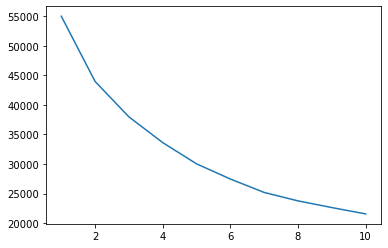

In [27]:
plt.plot(range(1,11), wss)

In [28]:
k_means=KMeans(n_clusters=3)
k_means.fit(scaled_service)
k_means.inertia_


37960.65732199036

In [29]:
from sklearn.metrics import silhouette_samples, silhouette_score
# Calculating silhouette_score
silhouette_score(scaled_service,k_means.labels_)

0.21230948587132023

In [30]:
service["Clus_kmeans"] = k_means.labels_
service.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,CC_Contacted_LY,Service_Score,CC_Agent_Score,Complain_ly,Day_Since_CC_connect,Clus_kmeans
0,6.0,3.0,2.0,1.0,5.0,0
1,8.0,3.0,3.0,1.0,0.0,0
2,30.0,2.0,3.0,1.0,3.0,0
3,15.0,2.0,5.0,0.0,3.0,1
4,12.0,2.0,5.0,0.0,3.0,1


In [31]:
np.round(service.groupby(by='Clus_kmeans').mean(),2)

,CC_Contacted_LY,Service_Score,CC_Agent_Score,Complain_ly,Day_Since_CC_connect
Clus_kmeans,,,,,
0,18.29,2.90,2.97,1.00,4.17
1,17.69,2.88,3.07,0.00,2.32
2,17.69,2.94,3.13,0.02,9.00


clus 0 - non complained   , Days since CC contact 9
clus 1 - non complained , CC contacted least , Days since CC contact 2
clus 2 - complained , Days since CC connect 4 , CC contacted 18

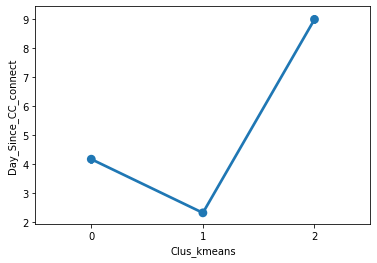

In [59]:
sns.pointplot(y=service.Day_Since_CC_connect,x=service.Clus_kmeans)

In [33]:
cust.head()

,City_Tier,Gender,Account_user_count,Marital_Status,Login_device
0,3.0,F,3.0,Single,Mobile
1,1.0,M,4.0,Single,Mobile
2,1.0,M,4.0,Single,Mobile
3,3.0,M,4.0,Single,Mobile
4,1.0,M,3.0,Single,Mobile


In [22]:
for feature in cust.columns: 
    if cust[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(cust[feature].unique()))
        print(pd.Categorical(cust[feature].unique()).codes)
        cust[feature] = pd.Categorical(cust[feature]).codes

NameError: name 'cust' is not defined

In [35]:
cust.head()

,City_Tier,Gender,Account_user_count,Marital_Status,Login_device
0,3.0,0,3.0,2,1
1,1.0,1,4.0,2,1
2,1.0,1,4.0,2,1
3,3.0,1,4.0,2,1
4,1.0,1,3.0,2,1


In [36]:
scaled_cust = X.fit_transform(cust)

In [37]:
wss2 =[] 
for i in range(1,11):
    KM2 = KMeans(n_clusters=i)
    KM2.fit(scaled_cust)
    wss2.append(KM2.inertia_)

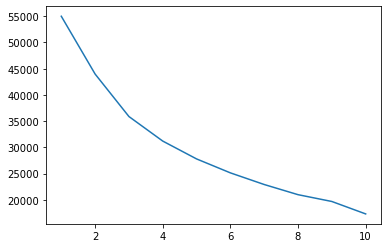

In [38]:
plt.plot(range(1,11), wss2)

In [39]:
k_means=KMeans(n_clusters=4)
k_means.fit(scaled_cust)
print(k_means.inertia_)
silhouette_score(scaled_cust,k_means.labels_)

30691.736225064695


0.2765894479918324

In [40]:
cust["Clus_kmeans"] = k_means.labels_

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
np.round(cust.groupby(by='Clus_kmeans').mean(),2)

,City_Tier,Gender,Account_user_count,Marital_Status,Login_device
Clus_kmeans,,,,,
0,1.07,1.00,3.65,1.13,1.0
1,1.65,0.61,3.73,1.19,0.0
2,3.00,0.59,3.75,1.16,1.0
3,1.05,0.00,3.71,1.15,1.0


clost 0  -  city tier 3 , Login device Mobile
clust 1  -  city tier 1 , Login device Mobile
clust 2  -  city tier 2 , Login device computer
clust 3  -  city tier 1 , Login device Mobile

In [42]:
money.head()

,cashback,account_segment,rev_per_month,rev_growth_yoy,coupon_used_for_payment
0,159.93,Super,9.0,11,1
1,120.90,Regular Plus,7.0,15,0
2,155.62,Regular Plus,6.0,14,0
3,134.07,Super,8.0,23,0
4,129.60,Regular Plus,3.0,11,1


In [15]:
for feature in money.columns: 
    if money[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(money[feature].unique()))
        print(pd.Categorical(money[feature].unique()).codes)
        money[feature] = pd.Categorical(money[feature]).codes



feature: account_segment
[Super, Regular Plus, Regular, HNI, Regular +, Super Plus, Super +]
Categories (7, object): [HNI, Regular, Regular +, Regular Plus, Super, Super +, Super Plus]
[4 3 1 0 2 6 5]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [44]:
scaled_money = X.fit_transform(money)

In [45]:
wss3 =[] 
for i in range(1,11):
    KM3 = KMeans(n_clusters=i)
    KM3.fit(scaled_money)
    wss3.append(KM3.inertia_)

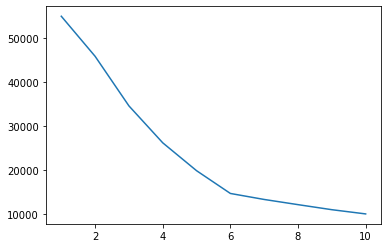

In [46]:
plt.plot(range(1,11), wss3)

In [47]:
k_means=KMeans(n_clusters=6)
k_means.fit(scaled_cust)
print(k_means.inertia_)
silhouette_score(scaled_cust,k_means.labels_)

25607.491693363165


0.31206909309273106

In [48]:
money["Clus_kmeans"] = k_means.labels_

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
np.round(money.groupby(by='Clus_kmeans').mean(),2)

,cashback,account_segment,rev_per_month,rev_growth_yoy,coupon_used_for_payment
Clus_kmeans,,,,,
0,192.86,3.21,5.45,16.12,1.40
1,174.66,2.96,6.30,16.24,1.88
2,179.53,2.98,6.61,16.00,1.88
3,206.95,2.88,6.34,16.27,1.72
4,194.31,3.20,6.07,16.36,1.87
5,208.43,3.08,5.84,16.22,1.99


## Imbalance data

In [11]:
X = dth.drop('Churn',axis=1)

In [12]:
y=dth.Churn

In [13]:
for feature in X.columns: 
    if X[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(X[feature].unique()))
        print(pd.Categorical(X[feature].unique()).codes)
        X[feature] = pd.Categorical(X[feature]).codes



feature: Payment
[Debit Card, UPI, Credit Card, Cash on Delivery, E wallet]
Categories (5, object): [Cash on Delivery, Credit Card, Debit Card, E wallet, UPI]
[2 4 1 0 3]


feature: Gender
[F, M]
Categories (2, object): [F, M]
[0 1]


feature: account_segment
[Super, Regular Plus, Regular, HNI, Regular +, Super Plus, Super +]
Categories (7, object): [HNI, Regular, Regular +, Regular Plus, Super, Super +, Super Plus]
[4 3 1 0 2 6 5]


feature: Marital_Status
[Single, Divorced, Married]
Categories (3, object): [Divorced, Married, Single]
[2 0 1]


feature: Login_device
[Mobile, Computer]
Categories (2, object): [Computer, Mobile]
[1 0]


In [14]:
oversample = SMOTE()
X_s, y_s = oversample.fit_resample(X, y)

In [15]:
counter=Counter(y_s)
counter


Counter({1: 9149, 0: 9149})

## Model Design

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size=.30, random_state=1)

In [17]:
print('Before SMOTE')
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('train_labels',train_labels.shape)
print('test_labels',test_labels.shape)

Before SMOTE
X_train (7700, 17)
X_test (3301, 17)
train_labels (7700,)
test_labels (3301,)


In [18]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [19]:
X_trains, X_tests, trains_labels, tests_labels = train_test_split(X_s, y_s, test_size=.30, random_state=1)
X_trains_sc = sc.fit_transform(X_trains)
X_tests_sc = sc.transform(X_tests)

In [20]:
print('After SMOTE')
print('X_train',X_trains.shape)
print('X_test',X_tests.shape)
print('train_labels',trains_labels.shape)
print('test_labels',tests_labels.shape)

After SMOTE
X_train (12808, 17)
X_test (5490, 17)
train_labels (12808,)
test_labels (5490,)


In [21]:
test_labels.value_counts(normalize=True)

0    0.83096
1    0.16904
Name: Churn, dtype: float64

In [22]:
tests_labels.value_counts(normalize=True)

0    0.504736
1    0.495264
Name: Churn, dtype: float64

## Without SMOTE

## LOGIT

Confusion Matrix


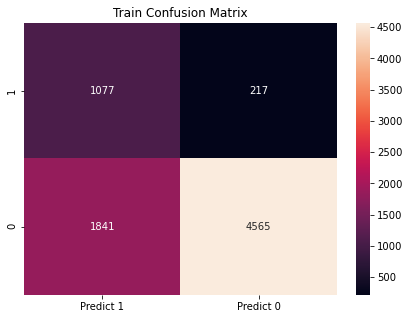

In [67]:
logit = LogisticRegression(class_weight='balanced' ,n_jobs=-1)
logit.fit(X_train,train_labels)
ytrain_predict=logit.predict(X_train)
y_predict = logit.predict(X_test)
coef_df = pd.DataFrame(logit.coef_, columns= X_train.columns)
coef_df['intercept'] = logit.intercept_
#plt.title('Train Confusion Matrix')
#sns.heatmap(confusion_matrix(train_labels,ytrain_predict),annot=True)
#sns.heatmap(confusion_matrix(test_labels,y_predict),annot=True)
print("Confusion Matrix")
cm=metrics.confusion_matrix(train_labels,ytrain_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Train Confusion Matrix')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

Confusion Matrix


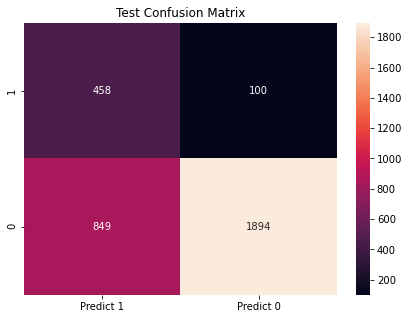

In [68]:
#sns.heatmap(confusion_matrix(test_labels,y_predict),annot=True)
print("Confusion Matrix")
cm=metrics.confusion_matrix(test_labels, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Test Confusion Matrix')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

In [69]:
logit_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(logit_metrics).transpose()
logit_train_precision=round(df.loc["1"][0],2)
logit_train_recall=round(df.loc["1"][1],2)
logit_train_f1=round(df.loc["1"][2],2)
print ('logit_train_precision ',logit_train_precision)
print ('logit_train_recall ',logit_train_recall)
print ('logit_train_f1 ',logit_train_f1)

logit_train_precision  0.37
logit_train_recall  0.83
logit_train_f1  0.51


In [28]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

           0       0.95      0.71      0.82      6406
           1       0.37      0.83      0.51      1294

    accuracy                           0.73      7700
   macro avg       0.66      0.77      0.66      7700
weighted avg       0.86      0.73      0.76      7700



In [70]:
logit_metrics=classification_report(test_labels, y_predict,output_dict=True)
df=pd.DataFrame(logit_metrics).transpose()
logit_test_precision=round(df.loc["1"][0],2)
logit_test_recall=round(df.loc["1"][1],2)
logit_test_f1=round(df.loc["1"][2],2)
print ('logit_test_precision ',logit_test_precision)
print ('logit_test_recall ',logit_test_recall)
print ('logit_test_f1 ',logit_test_f1)

logit_test_precision  0.35
logit_test_recall  0.82
logit_test_f1  0.49


In [42]:
print(classification_report(test_labels, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.69      0.80      2743
           1       0.35      0.82      0.49       558

    accuracy                           0.71      3301
   macro avg       0.65      0.76      0.65      3301
weighted avg       0.85      0.71      0.75      3301



Area under Curve Train is 0.7724580558894506
Area under Curve Test is 0.7556367005228036


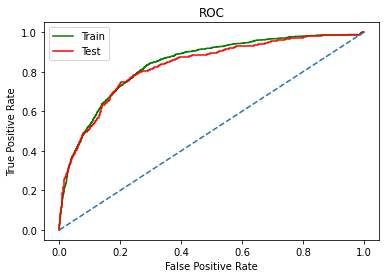

In [71]:
logit_train_fpr, logit_train_tpr,_=roc_curve(train_labels,logit.predict_proba(X_train)[:,1])
logit_test_fpr, logit_test_tpr,_=roc_curve(test_labels,logit.predict_proba(X_test)[:,1])
plt.plot(logit_train_fpr,logit_train_tpr,color='green',label='Train')
plt.plot(logit_test_fpr,logit_test_tpr,color='red',label='Test')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
logit_train_auc=roc_auc_score(train_labels,logit.predict(X_train))
logit_test_auc=roc_auc_score(test_labels,logit.predict(X_test))
print('Area under Curve Train is', logit_train_auc)
print('Area under Curve Test is', logit_test_auc)

In [23]:
coef_df.T

,0
Tenure,-0.085734
City_Tier,0.375706
CC_Contacted_LY,0.012815
Payment,-0.150579
Gender,0.095905
Service_Score,-0.136794
Account_user_count,0.324144
account_segment,-0.382006
CC_Agent_Score,0.251700
Marital_Status,0.517135


## Naive Bayes

Confusion Matrix


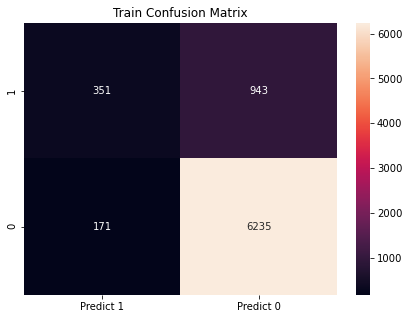

In [72]:
diab_model = GaussianNB()
diab_model.fit(X_train,train_labels)
ytrain_predict=diab_model.predict(X_train)
y_predict = diab_model.predict(X_test)
#coef_df = pd.DataFrame(diab_model.coef_, columns= X_train.columns)
#coef_df['intercept'] = diab_model.intercept_
print("Confusion Matrix")
cm=metrics.confusion_matrix(train_labels, ytrain_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Train Confusion Matrix')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

Confusion Matrix


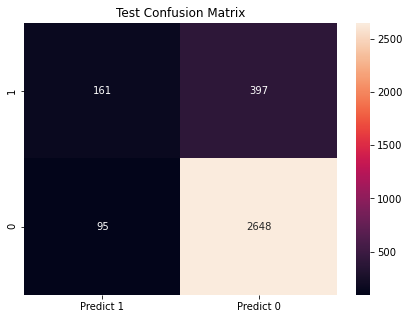

In [73]:
print("Confusion Matrix")
cm=metrics.confusion_matrix(test_labels, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Test Confusion Matrix')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

In [49]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6406
           1       0.67      0.27      0.39      1294

    accuracy                           0.86      7700
   macro avg       0.77      0.62      0.65      7700
weighted avg       0.84      0.86      0.83      7700



In [47]:
diab_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(diab_metrics).transpose()
diab_train_precision=round(df.loc["1"][0],2)
diab_train_recall=round(df.loc["1"][1],2)
diab_train_f1=round(df.loc["1"][2],2)
print ('diab_train_precision ',diab_train_precision)
print ('diab_train_recall ',diab_train_recall)
print ('diab_train_f1 ',diab_train_f1)

diab_train_precision  0.67
diab_train_recall  0.27
diab_train_f1  0.39


In [74]:
diab_metrics=classification_report(test_labels, y_predict,output_dict=True)
df=pd.DataFrame(diab_metrics).transpose()
diab_test_precision=round(df.loc["1"][0],2)
diab_test_recall=round(df.loc["1"][1],2)
diab_test_f1=round(df.loc["1"][2],2)
print ('diab_test_precision ',diab_test_precision)
print ('diab_test_recall ',diab_test_recall)
print ('diab_test_f1 ',diab_test_f1)

diab_test_precision  0.63
diab_test_recall  0.29
diab_test_f1  0.4


In [75]:
print(classification_report(test_labels, y_predict))

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      2743
           1       0.63      0.29      0.40       558

    accuracy                           0.85      3301
   macro avg       0.75      0.63      0.66      3301
weighted avg       0.83      0.85      0.83      3301



Area under Curve Train is 0.6222791036803306
Area under Curve Test is 0.6269484265585779


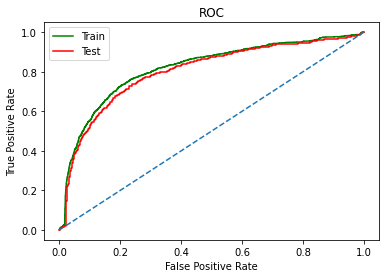

In [76]:
diab_train_fpr, diab_train_tpr,_=roc_curve(train_labels,diab_model.predict_proba(X_train)[:,1])
diab_test_fpr, diab_test_tpr,_=roc_curve(test_labels,diab_model.predict_proba(X_test)[:,1])
plt.plot(diab_train_fpr,diab_train_tpr,color='green',label='Train')
plt.plot(diab_test_fpr,diab_test_tpr,color='red',label='Test')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
diab_train_auc=roc_auc_score(train_labels,diab_model.predict(X_train))
diab_test_auc=roc_auc_score(test_labels,diab_model.predict(X_test))
print('Area under Curve Train is', diab_train_auc)
print('Area under Curve Test is', diab_test_auc)

## KNeighborsClassifier

Misclassification error (MCE) = 1 - Test accuracy score. Calculated MCE for each model with neighbours = 1,3,5...19 and find the 
model with lowest MCE

In [73]:
# empty list that will hold accuracy scores
ac_scores = []

# perform accuracy metrics for values from 1,3,5....19
for k in range(1,20,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, train_labels)
    # evaluate accuracy
    scores = knn.score(X_test, test_labels)
    ac_scores.append(scores)

# changing to misclassification error
MCE = [1 - x for x in ac_scores]
MCE


[0.09663738261132993,
 0.12420478642835509,
 0.13480763405028784,
 0.13511057255377157,
 0.1363223265677067,
 0.14086640411996365,
 0.1448046046652529,
 0.14601635867918816,
 0.14783398970009087,
 0.1472281126931233]

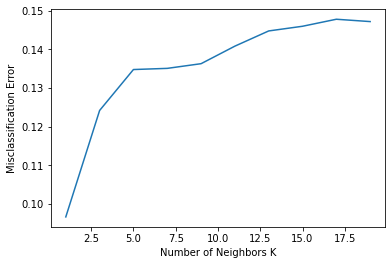

In [74]:
import matplotlib.pyplot as plt
# plot misclassification error vs k
plt.plot(range(1,20,2), MCE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

Confusion Matrix


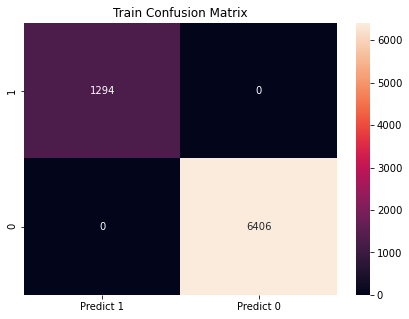

In [77]:
KNN_model=KNeighborsClassifier(n_neighbors = 1,metric='euclidean')
KNN_model.fit(X_train,train_labels)
ytrain_predict=KNN_model.predict(X_train)
y_predict = KNN_model.predict(X_test)
#coef_df = pd.DataFrame(KNN_model.coef_, columns= X_train.columns)
#coef_df['intercept'] = KNN_model.intercept_
print("Confusion Matrix")
cm=metrics.confusion_matrix(train_labels, ytrain_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Train Confusion Matrix')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

Confusion Matrix


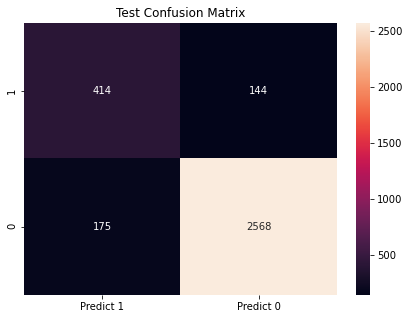

In [78]:
print("Confusion Matrix")
cm=metrics.confusion_matrix(test_labels, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Test Confusion Matrix')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

In [54]:
KNN_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(KNN_metrics).transpose()
KNN_train_precision=round(df.loc["1"][0],2)
KNN_train_recall=round(df.loc["1"][1],2)
KNN_train_f1=round(df.loc["1"][2],2)
print ('KNN_train_precision ',KNN_train_precision)
print ('KNN_train_recall ',KNN_train_recall)
print ('KNN_train_f1 ',KNN_train_f1)

KNN_train_precision  1.0
KNN_train_recall  1.0
KNN_train_f1  1.0


In [57]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6406
           1       1.00      1.00      1.00      1294

    accuracy                           1.00      7700
   macro avg       1.00      1.00      1.00      7700
weighted avg       1.00      1.00      1.00      7700



In [79]:
KNN_metrics=classification_report(test_labels, y_predict,output_dict=True)
df=pd.DataFrame(KNN_metrics).transpose()
KNN_test_precision=round(df.loc["1"][0],2)
KNN_test_recall=round(df.loc["1"][1],2)
KNN_test_f1=round(df.loc["1"][2],2)
print ('KNN_test_precision ',KNN_test_precision)
print ('KNN_test_recall ',KNN_test_recall)
print ('KNN_test_f1 ',KNN_test_f1)

KNN_test_precision  0.7
KNN_test_recall  0.74
KNN_test_f1  0.72


In [80]:
print(classification_report(test_labels, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2743
           1       0.70      0.74      0.72       558

    accuracy                           0.90      3301
   macro avg       0.82      0.84      0.83      3301
weighted avg       0.91      0.90      0.90      3301



Area under Curve Train is 1.0
Area under Curve Test is 0.8390683616948714


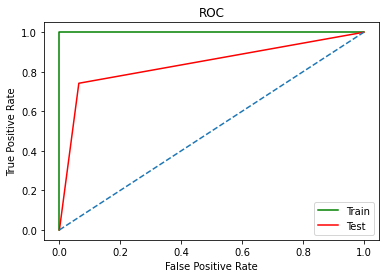

In [82]:
KNN_train_fpr, KNN_train_tpr,_=roc_curve(train_labels,KNN_model.predict_proba(X_train)[:,1])
KNN_test_fpr, KNN_test_tpr,_=roc_curve(test_labels,KNN_model.predict_proba(X_test)[:,1])
plt.plot(KNN_train_fpr,KNN_train_tpr,color='green',label='Train')
plt.plot(KNN_test_fpr,KNN_test_tpr,color='red',label='Test')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC')
KNN_train_auc=roc_auc_score(train_labels,KNN_model.predict(X_train))
KNN_test_auc=roc_auc_score(test_labels,KNN_model.predict(X_test))
print('Area under Curve Train is', KNN_train_auc)
print('Area under Curve Test is', KNN_test_auc)

## Decision Tree

Confusion Matrix


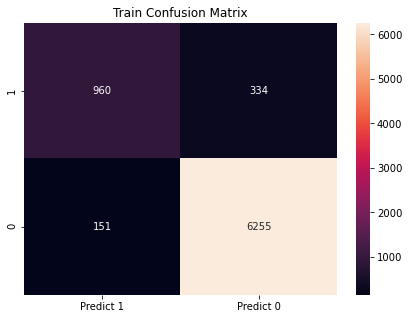

In [18]:
dTreeR = DecisionTreeClassifier(criterion = 'gini', max_depth = 8, random_state=1)
dTreeR.fit(X_train, train_labels)
ytrain_predict=dTreeR.predict(X_train)
y_predict = dTreeR.predict(X_test)
coef_df = pd.DataFrame(dTreeR.feature_importances_, columns = ["Imp"], index = X_train.columns)
#coef_df['intercept'] = dTreeR.intercept_
print("Confusion Matrix")
cm=metrics.confusion_matrix(train_labels, ytrain_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Train Confusion Matrix')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

Confusion Matrix


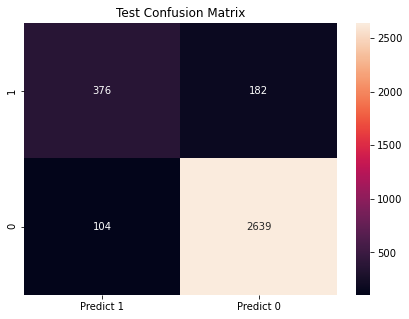

In [20]:
print("Confusion Matrix")
cm=metrics.confusion_matrix(test_labels, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Test Confusion Matrix')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

In [59]:
dTreeR_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(dTreeR_metrics).transpose()
dTreeR_train_precision=round(df.loc["1"][0],2)
dTreeR_train_recall=round(df.loc["1"][1],2)
dTreeR_train_f1=round(df.loc["1"][2],2)
print ('dTreeR_train_precision ',dTreeR_train_precision)
print ('dTreeR_train_recall ',dTreeR_train_recall)
print ('dTreeR_train_f1 ',dTreeR_train_f1)

dTreeR_train_precision  0.86
dTreeR_train_recall  0.74
dTreeR_train_f1  0.8


In [60]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      6406
           1       0.86      0.74      0.80      1294

    accuracy                           0.94      7700
   macro avg       0.91      0.86      0.88      7700
weighted avg       0.93      0.94      0.94      7700



In [62]:
dTreeR_metrics=classification_report(test_labels, y_predict,output_dict=True)
df=pd.DataFrame(dTreeR_metrics).transpose()
dTreeR_test_precision=round(df.loc["1"][0],2)
dTreeR_test_recall=round(df.loc["1"][1],2)
dTreeR_test_f1=round(df.loc["1"][2],2)
print ('dTreeR_test_precision ',dTreeR_test_precision)
print ('dTreeR_test_recall ',dTreeR_test_recall)
print ('dTreeR_test_f1 ',dTreeR_test_f1)

dTreeR_test_precision  0.78
dTreeR_test_recall  0.67
dTreeR_test_f1  0.72


In [63]:
print(classification_report(test_labels, y_predict))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2743
           1       0.78      0.67      0.72       558

    accuracy                           0.91      3301
   macro avg       0.86      0.82      0.84      3301
weighted avg       0.91      0.91      0.91      3301



Area under Curve Train is 0.859156987194675
Area under Curve Test is 0.8179602167524505


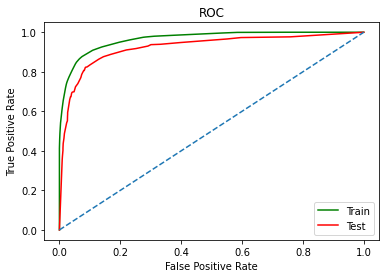

In [21]:
dTreeR_train_fpr, dTreeR_train_tpr,_=roc_curve(train_labels,dTreeR.predict_proba(X_train)[:,1])
dTreeR_test_fpr, dTreeR_test_tpr,_=roc_curve(test_labels,dTreeR.predict_proba(X_test)[:,1])
plt.plot(dTreeR_train_fpr,dTreeR_train_tpr,color='green',label='Train')
plt.plot(dTreeR_test_fpr,dTreeR_test_tpr,color='red',label='Test')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC')
dTreeR_train_auc=roc_auc_score(train_labels,dTreeR.predict(X_train))
dTreeR_test_auc=roc_auc_score(test_labels,dTreeR.predict(X_test))
print('Area under Curve Train is', dTreeR_train_auc)
print('Area under Curve Test is', dTreeR_test_auc)

In [52]:
train_char_label = ['No', 'Yes']
Credit_Tree_FileR = open('credit_treeR.dot','w')
dot_data = tree.export_graphviz(dTreeR, out_file=Credit_Tree_FileR, feature_names = list(X_train), class_names = list(train_char_label))
CCredit_Tree_FileR.close()

#Works only if "dot" command works on you machine

retCode = system("dot -Tpng credit_treeR.dot -o credit_treeR.png")
if(retCode>0):
    print("system command returning error: "+str(retCode))
else:
    display(Image("credit_treeR.png"))



system command returning error: 1


In [101]:
import pydotplus
train_char_label = ['No', 'Yes']
Credit_Tree_FileR = open('credit_treeR.dot','w')
dot_data = tree.export_graphviz(dTreeR, out_file=Credit_Tree_FileR, feature_names = list(X_train), class_names = list(train_char_label))

graph=pydotplus.graph_from_dot_data(dot_data.getvalue())

# Display inline image of Tree - Inline image is not useful

Img=(Image(graph.create_png()))

display(Img)
 

#Write image to file so it can be rotated and expanded

graph.write_png('Your_File_Name.png')

TypeError: object of type 'NoneType' has no len()

In [53]:
print (pd.DataFrame(dTreeR.feature_importances_, columns = ["Imp"], index = X_train.columns))

                              Imp
Tenure                   0.420494
City_Tier                0.020748
CC_Contacted_LY          0.030689
Payment                  0.026666
Gender                   0.002395
Service_Score            0.005477
Account_user_count       0.027494
account_segment          0.051374
CC_Agent_Score           0.078102
Marital_Status           0.041547
rev_per_month            0.036742
Complain_ly              0.085796
rev_growth_yoy           0.040669
coupon_used_for_payment  0.012764
Day_Since_CC_connect     0.086323
cashback                 0.016864
Login_device             0.015856


## Ensemble

Confusion Matrix


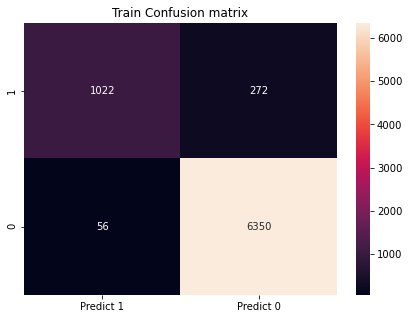

In [87]:
from sklearn.ensemble import BaggingClassifier
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1,max_depth = 8)
bgcl = BaggingClassifier(base_estimator=dTree, n_estimators=50,random_state=1)
#bgcl = BaggingClassifier(n_estimators=50,random_state=1)

bgcl = bgcl.fit(X_train, train_labels)
ytrain_predict=bgcl.predict(X_train)
y_predict = bgcl.predict(X_test)
#coef_df =  pd.DataFrame(bgcl.feature_importances_, columns = ["Imp"], index = X_train.columns)
#coef_df['intercept'] = bgcl.intercept_
print("Confusion Matrix")
cm=metrics.confusion_matrix(train_labels, ytrain_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Train Confusion matrix')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

In [88]:
bgcl_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(bgcl_metrics).transpose()
bgcl_train_precision=round(df.loc["1"][0],2)
bgcl_train_recall=round(df.loc["1"][1],2)
bgcl_train_f1=round(df.loc["1"][2],2)
print ('bgcl_train_precision ',bgcl_train_precision)
print ('bgcl_train_recall ',bgcl_train_recall)
print ('bgcl_train_f1 ',bgcl_train_f1)
print('accuracy',bgcl.score(X_train, train_labels))

bgcl_train_precision  0.95
bgcl_train_recall  0.79
bgcl_train_f1  0.86
accuracy 0.9574025974025974


In [25]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6406
           1       0.95      0.79      0.86      1294

    accuracy                           0.96      7700
   macro avg       0.95      0.89      0.92      7700
weighted avg       0.96      0.96      0.96      7700



In [89]:
bgcl_metrics=classification_report(test_labels, y_predict,output_dict=True)
df=pd.DataFrame(bgcl_metrics).transpose()
bgcl_test_precision=round(df.loc["1"][0],2)
bgcl_test_recall=round(df.loc["1"][1],2)
bgcl_test_f1=round(df.loc["1"][2],2)
print ('bgcl_test_precision ',bgcl_test_precision)
print ('bgcl_test_recall ',bgcl_test_recall)
print ('bgcl_test_f1 ',bgcl_test_f1)
print('accuracy',bgcl.score(X_test, test_labels))

bgcl_test_precision  0.86
bgcl_test_recall  0.7
bgcl_test_f1  0.77
accuracy 0.9303241441987277


In [28]:
print(classification_report(test_labels, y_predict))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2743
           1       0.86      0.70      0.77       558

    accuracy                           0.93      3301
   macro avg       0.90      0.84      0.87      3301
weighted avg       0.93      0.93      0.93      3301



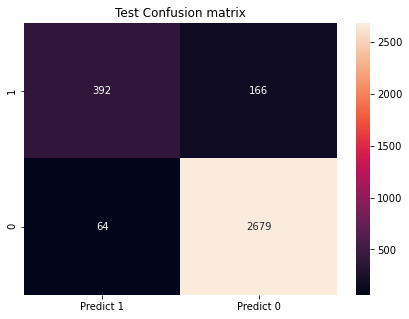

In [24]:
cm=metrics.confusion_matrix(test_labels, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Test Confusion matrix')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

Area under Curve Train is 0.8905286340423704
Area under Curve Test is 0.8395884212273144


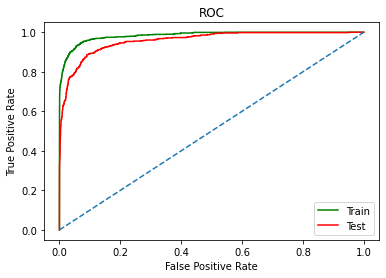

In [29]:
bgcl_train_fpr, bgcl_train_tpr,_=roc_curve(train_labels,bgcl.predict_proba(X_train)[:,1])
bgcl_test_fpr, bgcl_test_tpr,_=roc_curve(test_labels,bgcl.predict_proba(X_test)[:,1])
plt.plot(bgcl_train_fpr,bgcl_train_tpr,color='green',label='Train')
plt.plot(bgcl_test_fpr,bgcl_test_tpr,color='red',label='Test')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
bgcl_train_auc=roc_auc_score(train_labels,bgcl.predict(X_train))
bgcl_test_auc=roc_auc_score(test_labels,bgcl.predict(X_test))
print('Area under Curve Train is', bgcl_train_auc)
print('Area under Curve Test is', bgcl_test_auc)

In [61]:
print (pd.DataFrame(bgcl.feature_importances_, columns = ["Imp"], index = X_train.columns))

AttributeError: 'BaggingClassifier' object has no attribute 'feature_importances_'

## RF

In [35]:
param_grid = {
    'max_depth': [10,12],
    'max_features': [6,3],
    'min_samples_leaf': [10,30],
    'min_samples_split': [50,100],
    'n_estimators': [300]
}

rfcl = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rfcl, param_grid = param_grid, cv = 5,n_jobs=-1)

In [62]:
from sklearn.ensemble import RandomForestClassifier


{'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 300}
Confusion Matrix


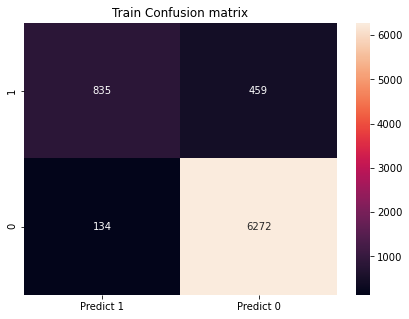

In [36]:
grid_search.fit(X_train, train_labels)
print(grid_search.best_params_)
ytrain_predict=grid_search.predict(X_train)
y_predict = grid_search.predict(X_test)
#coef_df = pd.DataFrame(grid_search.feature_importances_, columns= X_train.columns)
#coef_df['intercept'] = grid_search.intercept_
print("Confusion Matrix")
cm=metrics.confusion_matrix(train_labels, ytrain_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Train Confusion matrix')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

In [37]:
rf_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(rf_metrics).transpose()
rf_train_precision=round(df.loc["1"][0],2)
rf_train_recall=round(df.loc["1"][1],2)
rf_train_f1=round(df.loc["1"][2],2)
print ('rf_train_precision ',rf_train_precision)
print ('rf_train_recall ',rf_train_recall)
print ('rf_train_f1 ',rf_train_f1)

rf_train_precision  0.86
rf_train_recall  0.65
rf_train_f1  0.74


In [38]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      6406
           1       0.86      0.65      0.74      1294

    accuracy                           0.92      7700
   macro avg       0.90      0.81      0.85      7700
weighted avg       0.92      0.92      0.92      7700



In [39]:
rf_metrics=classification_report(test_labels, y_predict,output_dict=True)
df=pd.DataFrame(rf_metrics).transpose()
rf_test_precision=round(df.loc["1"][0],2)
rf_test_recall=round(df.loc["1"][1],2)
rf_test_f1=round(df.loc["1"][2],2)
print ('rf_test_precision ',rf_test_precision)
print ('rf_test_recall ',rf_test_recall)
print ('rf_test_f1 ',rf_test_f1)

rf_test_precision  0.8
rf_test_recall  0.61
rf_test_f1  0.69


In [43]:
print(classification_report(test_labels, y_predict))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      2743
           1       0.80      0.61      0.69       558

    accuracy                           0.91      3301
   macro avg       0.86      0.79      0.82      3301
weighted avg       0.90      0.91      0.90      3301



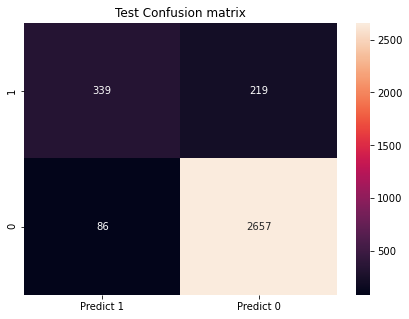

In [42]:
cm=metrics.confusion_matrix(test_labels, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Test Confusion matrix')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

Area under Curve Train is 0.8121840228031969
Area under Curve Test is 0.788087173999114


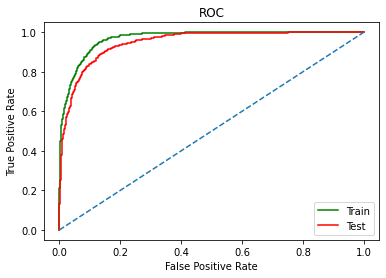

In [44]:
rf_train_fpr, rf_train_tpr,_=roc_curve(train_labels,grid_search.predict_proba(X_train)[:,1])
rf_test_fpr, rf_test_tpr,_=roc_curve(test_labels,grid_search.predict_proba(X_test)[:,1])
plt.plot(rf_train_fpr,rf_train_tpr,color='green',label='Train')
plt.plot(rf_test_fpr,rf_test_tpr,color='red',label='Test')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
rf_train_auc=roc_auc_score(train_labels,grid_search.predict(X_train))
rf_test_auc=roc_auc_score(test_labels,grid_search.predict(X_test))
print('Area under Curve Train is', rf_train_auc)
print('Area under Curve Test is', rf_test_auc)

In [72]:
print (pd.DataFrame(grid_search.feature_importances_, columns = ["Imp"], index = X_train.columns))

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

## XGB

In [24]:
import xgboost as xgb
model = xgb.XGBClassifier()


Confusion Matrix


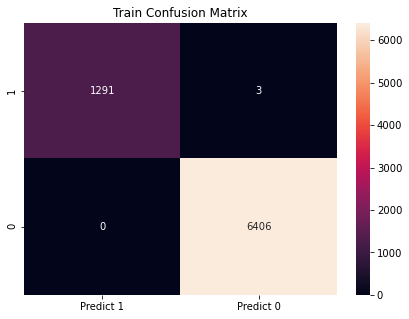

In [25]:
model.fit(X_train, train_labels)
#print(grid_search.best_params_)
ytrain_predict=model.predict(X_train)
y_predict = model.predict(X_test)
coef_df = pd.DataFrame(model.feature_importances_, columns = ["Imp"], index = X_train.columns)
#coef_df['intercept'] = grid_search.intercept_
print("Confusion Matrix")
cm=metrics.confusion_matrix(train_labels, ytrain_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Train Confusion Matrix')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

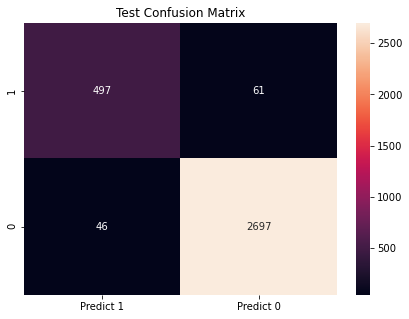

In [26]:
cm=metrics.confusion_matrix(test_labels, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Test Confusion Matrix')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

In [27]:
xgb_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(xgb_metrics).transpose()
xgb_train_precision=round(df.loc["1"][1],2)
xgb_train_recall=round(df.loc["1"][2],2)
xgb_train_f1=round(df.loc["1"][0],2)
print ('xgb_train_precision ',xgb_train_precision)
print ('xgb_train_recall ',xgb_train_recall)
print ('xgb_train_f1 ',xgb_train_f1)

xgb_train_precision  1.0
xgb_train_recall  1.0
xgb_train_f1  1.0


In [28]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6406
           1       1.00      1.00      1.00      1294

    accuracy                           1.00      7700
   macro avg       1.00      1.00      1.00      7700
weighted avg       1.00      1.00      1.00      7700



In [29]:
xgb_metrics=classification_report(test_labels, y_predict,output_dict=True)
df=pd.DataFrame(xgb_metrics).transpose()
xgb_test_precision=round(df.loc["1"][1],2)
xgb_test_recall=round(df.loc["1"][2],2)
xgb_test_f1=round(df.loc["1"][0],2)
print ('xgb_test_precision ',xgb_test_precision)
print ('xgb_test_recall ',xgb_test_recall)
print ('xgb_test_f1 ',xgb_test_f1)

xgb_test_precision  0.89
xgb_test_recall  0.9
xgb_test_f1  0.92


In [30]:
print(classification_report(test_labels, y_predict))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2743
           1       0.92      0.89      0.90       558

    accuracy                           0.97      3301
   macro avg       0.95      0.94      0.94      3301
weighted avg       0.97      0.97      0.97      3301



Area under Curve Train is 0.9988408037094281
Area under Curve Test is 0.9369555218431538


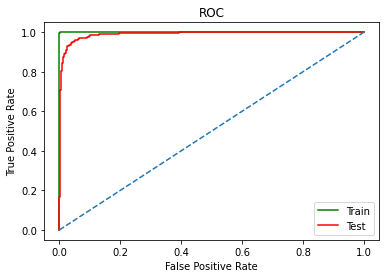

In [31]:
xgb_train_fpr, xgb_train_tpr,_=roc_curve(train_labels,model.predict_proba(X_train)[:,1])
xgb_test_fpr, xgb_test_tpr,_=roc_curve(test_labels,model.predict_proba(X_test)[:,1])
plt.plot(xgb_train_fpr,xgb_train_tpr,color='green',label='Train')
plt.plot(xgb_test_fpr,xgb_test_tpr,color='red',label='Test')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC')
xgb_train_auc=roc_auc_score(train_labels,model.predict(X_train))
xgb_test_auc=roc_auc_score(test_labels,model.predict(X_test))
print('Area under Curve Train is', xgb_train_auc)
print('Area under Curve Test is', xgb_test_auc)

# With SMOTE

## LOGIT

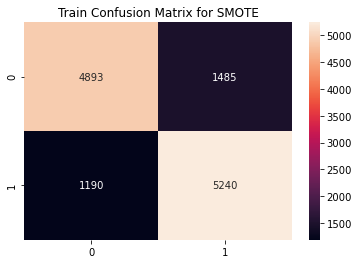

In [98]:
logit = LogisticRegression(class_weight='balanced' ,n_jobs=-1)
logit.fit(X_trains,trains_labels)
ytrains_predict=logit.predict(X_trains)
ys_predict = logit.predict(X_tests)
coef_df = pd.DataFrame(logit.coef_, columns= X_trains.columns)
coef_df['intercept'] = logit.intercept_
plt.title('Train Confusion Matrix for SMOTE')
sns.heatmap(confusion_matrix(trains_labels,ytrains_predict),annot=True,fmt='.5g')

Confusion Matrix


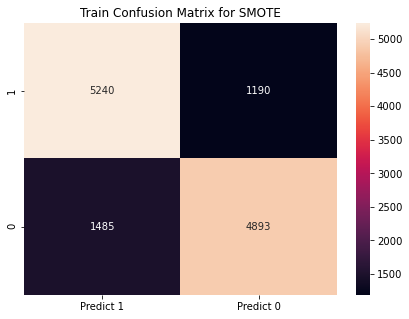

In [99]:
#sns.heatmap(confusion_matrix(tests_labels,ys_predict),annot=True)
print("Confusion Matrix")
cm=metrics.confusion_matrix(trains_labels,ytrains_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Train Confusion Matrix for SMOTE')
sns.heatmap(df_cm, annot=True,fmt='.5g')

In [101]:
print(classification_report(trains_labels,ytrains_predict))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      6378
           1       0.78      0.81      0.80      6430

    accuracy                           0.79     12808
   macro avg       0.79      0.79      0.79     12808
weighted avg       0.79      0.79      0.79     12808



Confusion Matrix


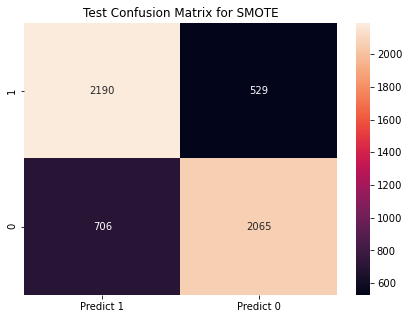

In [89]:
#sns.heatmap(confusion_matrix(tests_labels,ys_predict),annot=True)
print("Confusion Matrix")
cm=metrics.confusion_matrix(tests_labels, ys_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Test Confusion Matrix for SMOTE')
sns.heatmap(df_cm, annot=True,fmt='.5g')

In [67]:
logit_metrics=classification_report(trains_labels, ytrains_predict,output_dict=True)
df=pd.DataFrame(logit_metrics).transpose()
logits_train_precision=round(df.loc["1"][0],2)
logits_train_recall=round(df.loc["1"][1],2)
logits_train_f1=round(df.loc["1"][2],2)
print ('logit_smote_train_precision ',logits_train_precision)
print ('logit_smote_train_recall ',logits_train_recall)
print ('logit_smote_train_f1 ',logits_train_f1)
print('accuracy',logit.score(X_trains,trains_labels))

logit_smote_train_precision  0.78
logit_smote_train_recall  0.81
logit_smote_train_f1  0.8
accuracy 0.7911461586508433


In [68]:
logit_metrics=classification_report(tests_labels, ys_predict,output_dict=True)
df=pd.DataFrame(logit_metrics).transpose()
logits_test_precision=round(df.loc["1"][0],2)
logits_test_recall=round(df.loc["1"][1],2)
logits_test_f1=round(df.loc["1"][2],2)
print ('logit_smote_test_precision ',logits_test_precision)
print ('logit_smote_test_recall ',logits_test_recall)
print ('logit_smote_test_f1 ',logits_test_f1)
print('accuracy',logit.score(X_tests,tests_labels))

logit_smote_test_precision  0.76
logit_smote_test_recall  0.8
logit_smote_test_f1  0.78
accuracy 0.7770491803278688


In [105]:
print(classification_report(tests_labels, ys_predict))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      2771
           1       0.76      0.80      0.78      2719

    accuracy                           0.78      5490
   macro avg       0.78      0.78      0.78      5490
weighted avg       0.78      0.78      0.78      5490



  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24572 sha256=4b5a44dc36279a1b5df58dd23dacd1d5066177fb5decdf07dc34cd0b06894aa7
  Stored in directory: c:\users\shantanu hamdapurkar\appdata\local\pip\cache\wheels\1e\7b\04\7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


Area under Curve Train is 0.7827476302433471
Area under Curve Test is 0.7753307551853518


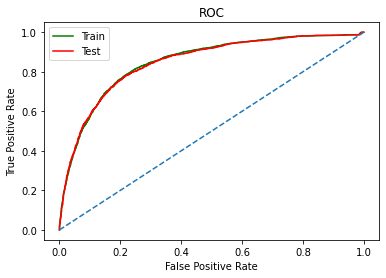

In [93]:
logits_train_fpr, logits_train_tpr,_=roc_curve(trains_labels,logit.predict_proba(X_trains)[:,1])
logits_test_fpr, logits_test_tpr,_=roc_curve(tests_labels,logit.predict_proba(X_tests)[:,1])
plt.plot(logits_train_fpr,logits_train_tpr,color='green',label='Train')
plt.plot(logits_test_fpr,logits_test_tpr,color='red',label='Test')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC')
logits_train_auc=roc_auc_score(trains_labels,logit.predict(X_trains))
logits_test_auc=roc_auc_score(tests_labels,logit.predict(X_tests))
print('Area under Curve Train is', logits_train_auc)
print('Area under Curve Test is', logits_test_auc)

## Naive Bayes

Confusion Matrix


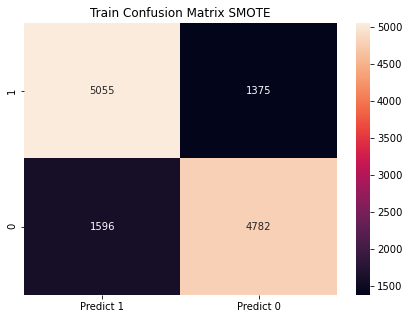

In [106]:
diab_models = GaussianNB()
diab_models.fit(X_trains,trains_labels)
ytrains_predict=diab_models.predict(X_trains)
ys_predict = diab_models.predict(X_tests)
#coef_df = pd.DataFrame(diab_model.coef_, columns= X_train.columns)
#coef_df['intercept'] = diab_model.intercept_
print("Confusion Matrix")
cm=metrics.confusion_matrix(trains_labels, ytrains_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Train Confusion Matrix SMOTE')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

Confusion Matrix


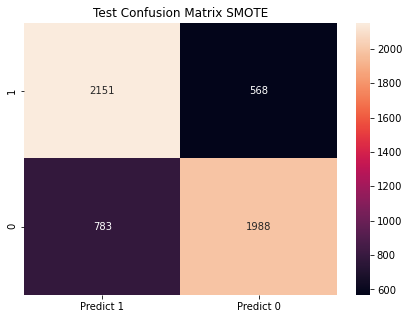

In [106]:
print("Confusion Matrix")
cm=metrics.confusion_matrix(tests_labels, ys_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Test Confusion Matrix SMOTE')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

In [70]:
diab_metrics=classification_report(trains_labels, ytrains_predict,output_dict=True)
df=pd.DataFrame(diab_metrics).transpose()
diabs_train_precision=round(df.loc["1"][0],2)
diabs_train_recall=round(df.loc["1"][1],2)
diabs_train_f1=round(df.loc["1"][2],2)
print ('diab_smote_train_precision ',diabs_train_precision)
print ('diab_smote_train_recall ',diabs_train_recall)
print ('diab_smote_train_f1 ',diabs_train_f1)
print('accuracy',diab_models.score(X_trains,trains_labels))

diab_smote_train_precision  0.76
diab_smote_train_recall  0.79
diab_smote_train_f1  0.77
accuracy 0.7680356027482823


In [108]:
print(classification_report(trains_labels, ytrains_predict))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76      6378
           1       0.76      0.79      0.77      6430

    accuracy                           0.77     12808
   macro avg       0.77      0.77      0.77     12808
weighted avg       0.77      0.77      0.77     12808



In [71]:
diab_metrics=classification_report(tests_labels, ys_predict,output_dict=True)
df=pd.DataFrame(diab_metrics).transpose()
diabs_test_precision=round(df.loc["1"][0],2)
diabs_test_recall=round(df.loc["1"][1],2)
diabs_test_f1=round(df.loc["1"][2],2)
print ('diab_smote_test_precision ',diabs_test_precision)
print ('diab_smote_test_recall ',diabs_test_recall)
print ('diab_smote_test_f1 ',diabs_test_f1)
print('accuracy',diab_models.score(X_tests,tests_labels))

diab_smote_test_precision  0.74
diab_smote_test_recall  0.78
diab_smote_test_f1  0.76
accuracy 0.7561020036429873


In [107]:
print(classification_report(tests_labels, ys_predict))

              precision    recall  f1-score   support

           0       0.77      0.74      0.75      2771
           1       0.74      0.78      0.76      2719

    accuracy                           0.76      5490
   macro avg       0.76      0.76      0.76      5490
weighted avg       0.76      0.76      0.76      5490



Area under Curve Train is 0.7592510608248515
Area under Curve Test is 0.7542650997451804


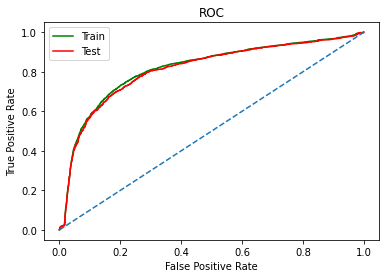

In [108]:
diabs_train_fpr, diabs_train_tpr,_=roc_curve(trains_labels,diab_models.predict_proba(X_trains)[:,1])
diabs_test_fpr, diabs_test_tpr,_=roc_curve(tests_labels,diab_models.predict_proba(X_tests)[:,1])
plt.plot(diabs_train_fpr,diabs_train_tpr,color='green',label='Train')
plt.plot(diabs_test_fpr,diabs_test_tpr,color='red',label='Test')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC')
diabs_train_auc=roc_auc_score(trains_labels,diab_models.predict(X_trains))
diabs_test_auc=roc_auc_score(tests_labels,diab_models.predict(X_tests))
print('Area under Curve Train is', diabs_train_auc)
print('Area under Curve Test is', diabs_test_auc)

## KNeighborsClassifier

In [98]:
# empty list that will hold accuracy scores
ac_scores = []

# perform accuracy metrics for values from 1,3,5....19
for k in range(1,20,2):
    knns = KNeighborsClassifier(n_neighbors=k)
    knns.fit(X_trains, trains_labels)
    # evaluate accuracy
    scores = knns.score(X_tests, tests_labels)
    ac_scores.append(scores)

# changing to misclassification error
MCE = [1 - x for x in ac_scores]
MCE

[0.04954462659380687,
 0.08214936247723137,
 0.10072859744990892,
 0.11238615664845175,
 0.12240437158469941,
 0.1311475409836066,
 0.13369763205828777,
 0.14134790528233154,
 0.1455373406193078,
 0.15063752276867026]

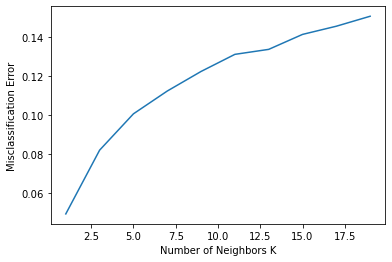

In [99]:
# plot misclassification error vs k
plt.plot(range(1,20,2), MCE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

Confusion Matrix


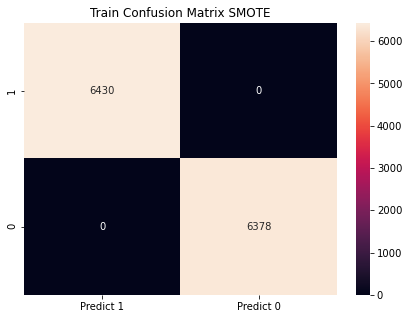

In [72]:
KNN_models=KNeighborsClassifier(n_neighbors = 1,metric='euclidean')
KNN_models.fit(X_trains,trains_labels)
ytrains_predict=KNN_models.predict(X_trains)
ys_predict = KNN_models.predict(X_tests)
#coef_df = pd.DataFrame(KNN_model.coef_, columns= X_train.columns)
#coef_df['intercept'] = KNN_model.intercept_
print("Confusion Matrix")
cm=metrics.confusion_matrix(trains_labels, ytrains_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Train Confusion Matrix SMOTE')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

Confusion Matrix


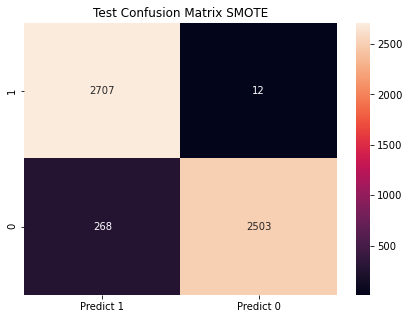

In [110]:
print("Confusion Matrix")
cm=metrics.confusion_matrix(tests_labels, ys_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Test Confusion Matrix SMOTE')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

In [73]:
KNN_metrics=classification_report(trains_labels, ytrains_predict,output_dict=True)
df=pd.DataFrame(KNN_metrics).transpose()
KNNs_train_precision=round(df.loc["1"][0],2)
KNNs_train_recall=round(df.loc["1"][1],2)
KNNs_train_f1=round(df.loc["1"][2],2)
print ('KNN_smote_train_precision ',KNNs_train_precision)
print ('KNN_smote_train_recall ',KNNs_train_recall)
print ('KNN_smote_train_f1 ',KNNs_train_f1)
print ('accuracy',KNN_models.score(X_trains,trains_labels))

KNN_smote_train_precision  1.0
KNN_smote_train_recall  1.0
KNN_smote_train_f1  1.0
accuracy 1.0


In [74]:
KNN_metrics=classification_report(tests_labels, ys_predict,output_dict=True)
df=pd.DataFrame(KNN_metrics).transpose()
KNNs_test_precision=round(df.loc["1"][0],2)
KNNs_test_recall=round(df.loc["1"][1],2)
KNNs_test_f1=round(df.loc["1"][2],2)
print ('KNN_smote_test_precision ',KNNs_test_precision)
print ('KNN_smote_test_recall ',KNNs_test_recall)
print ('KNN_smote_test_f1 ',KNNs_test_f1)
print ('accuracy',KNN_models.score(X_tests,tests_labels))

KNN_smote_test_precision  0.91
KNN_smote_test_recall  1.0
KNN_smote_test_f1  0.95
accuracy 0.9489981785063752


Area under Curve Train is 1.0
Area under Curve Test is 0.949435312858483


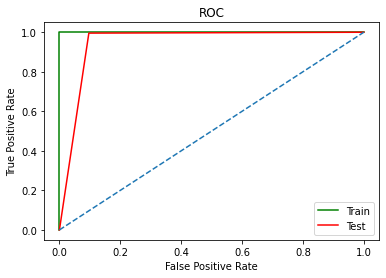

In [114]:
KNNs_train_fpr, KNNs_train_tpr,_=roc_curve(trains_labels,KNN_models.predict_proba(X_trains)[:,1])
KNNs_test_fpr, KNNs_test_tpr,_=roc_curve(tests_labels,KNN_models.predict_proba(X_tests)[:,1])
plt.plot(KNNs_train_fpr,KNNs_train_tpr,color='green',label='Train')
plt.plot(KNNs_test_fpr,KNNs_test_tpr,color='red',label='Test')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
KNNs_train_auc=roc_auc_score(trains_labels,KNN_models.predict(X_trains))
KNNs_test_auc=roc_auc_score(tests_labels,KNN_models.predict(X_tests))
print('Area under Curve Train is', KNNs_train_auc)
print('Area under Curve Test is', KNNs_test_auc)

## Decision Tree

Confusion Matrix


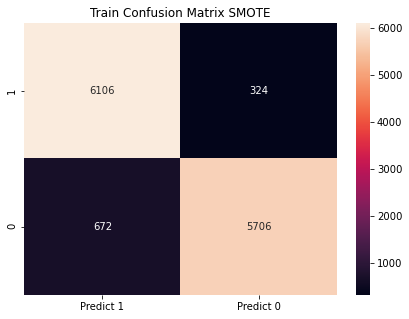

In [75]:
dTreeRs = DecisionTreeClassifier(criterion = 'gini', max_depth = 8, random_state=1)
dTreeRs.fit(X_trains, trains_labels)
ytrains_predict=dTreeRs.predict(X_trains)
ys_predict = dTreeRs.predict(X_tests)
coef_df = pd.DataFrame(dTreeRs.feature_importances_ , columns = ["Imp"], index = X_trains.columns)
#coef_df['intercept'] = dTreeR.intercept_
print("Confusion Matrix")
cm=metrics.confusion_matrix(trains_labels, ytrains_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Train Confusion Matrix SMOTE')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

Confusion Matrix


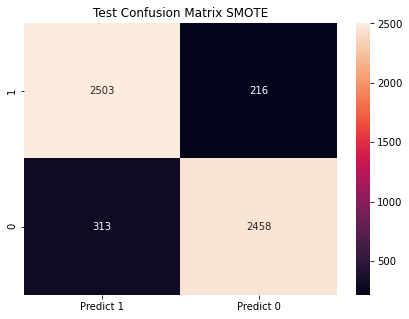

In [117]:
print("Confusion Matrix")
cm=metrics.confusion_matrix(tests_labels, ys_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Test Confusion Matrix SMOTE')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

In [76]:
dTreeR_metrics=classification_report(trains_labels, ytrains_predict,output_dict=True)
df=pd.DataFrame(dTreeR_metrics).transpose()
dTreeRs_train_precision=round(df.loc["1"][0],2)
dTreeRs_train_recall=round(df.loc["1"][1],2)
dTreeRs_train_f1=round(df.loc["1"][2],2)
print ('dTreeR_smote_train_precision ',dTreeRs_train_precision)
print ('dTreeR_smote_train_recall ',dTreeRs_train_recall)
print ('dTreeR_smote_train_f1 ',dTreeRs_train_f1)
print('accuracy',dTreeRs.score(X_trains,trains_labels))

dTreeR_smote_train_precision  0.9
dTreeR_smote_train_recall  0.95
dTreeR_smote_train_f1  0.92
accuracy 0.9222361024359775


In [77]:
dTreeR_metrics=classification_report(tests_labels, ys_predict,output_dict=True)
df=pd.DataFrame(dTreeR_metrics).transpose()
dTreeRs_test_precision=round(df.loc["1"][0],2)
dTreeRs_test_recall=round(df.loc["1"][1],2)
dTreeRs_test_f1=round(df.loc["1"][2],2)
print ('dTreeR_smote_test_precision ',dTreeRs_test_precision)
print ('dTreeR_smote_test_recall ',dTreeRs_test_recall)
print ('dTreeR_smote_test_f1 ',dTreeRs_test_f1)
print('accuracy',dTreeRs.score(X_tests,tests_labels))

dTreeR_smote_test_precision  0.88
dTreeR_smote_test_recall  0.93
dTreeR_smote_test_f1  0.91
accuracy 0.9052823315118397


Area under Curve Train is 0.9263711231307854
Area under Curve Test is 0.9038017086811349


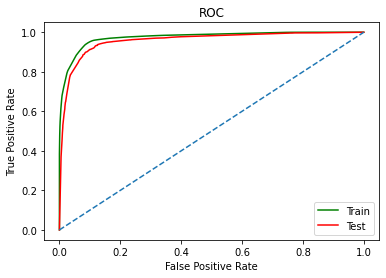

In [119]:
dTreeRs_train_fpr, dTreeRs_train_tpr,_=roc_curve(trains_labels,dTreeRs.predict_proba(X_trains)[:,1])
dTreeRs_test_fpr, dTreeRs_test_tpr,_=roc_curve(tests_labels,dTreeRs.predict_proba(X_tests)[:,1])
plt.plot(dTreeRs_train_fpr,dTreeRs_train_tpr,color='green',label='Train')
plt.plot(dTreeRs_test_fpr,dTreeRs_test_tpr,color='red',label='Test')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC')
dTreeRs_train_auc=roc_auc_score(trains_labels,dTreeRs.predict(X_trains))
dTreeRs_test_auc=roc_auc_score(tests_labels,dTreeRs.predict(X_tests))
print('Area under Curve Train is', dTreeRs_train_auc)
print('Area under Curve Test is', dTreeRs_test_auc)

In [116]:
train_char_label = ['No', 'Yes']
Credit_Tree_FileR = open('credit_treeR_smote2.dot','w')
dot_data = tree.export_graphviz(dTreeRs, out_file=Credit_Tree_FileR, feature_names = list(X_trains), class_names = list(train_char_label))
Credit_Tree_FileR.close()

#Works only if "dot" command works on you machine

retCode = system("dot -Tpng credit_treeR.dot -o credit_treeR.png")
if(retCode>0):
    print("system command returning error: "+str(retCode))
else:
    display(Image("credit_treeR.png"))

system command returning error: 1


In [117]:
print (pd.DataFrame(dTreeRs.feature_importances_, columns = ["Imp"], index = X_trains.columns))

                              Imp
Tenure                   0.500856
City_Tier                0.035182
CC_Contacted_LY          0.016031
Payment                  0.015351
Gender                   0.012102
Service_Score            0.004300
Account_user_count       0.018817
account_segment          0.026031
CC_Agent_Score           0.070197
Marital_Status           0.017914
rev_per_month            0.030377
Complain_ly              0.172230
rev_growth_yoy           0.014097
coupon_used_for_payment  0.003229
Day_Since_CC_connect     0.029403
cashback                 0.013017
Login_device             0.020867


## Ensemble with SMOTE

Confusion Matrix


AttributeError: 'QuadMesh' object has no property 'fmg'

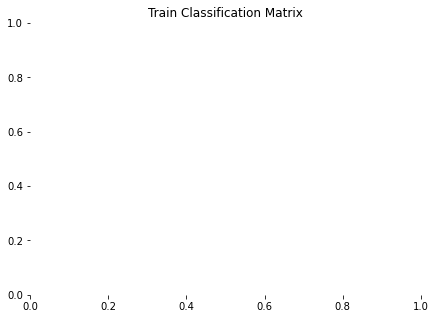

In [97]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1,max_depth = 8)
bgcls = BaggingClassifier(base_estimator=dTree, n_estimators=50,random_state=1)
#bgcl = BaggingClassifier(n_estimators=50,random_state=1)

bgcls = bgcls.fit(X_trains, trains_labels)
ytrains_predict=bgcls.predict(X_trains)
ys_predict = bgcls.predict(X_tests)
#coef_df =  pd.DataFrame(bgcl.feature_importances_, columns = ["Imp"], index = X_train.columns)
#coef_df['intercept'] = bgcl.intercept_
print("Confusion Matrix")
cm=metrics.confusion_matrix(trains_labels, ytrains_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Train Classification Matrix')
sns.heatmap(df_cm, annot=True,fmg='0.5g')

In [79]:

bgcl_metrics=classification_report(trains_labels, ytrains_predict,output_dict=True)
df=pd.DataFrame(bgcl_metrics).transpose()
bgcls_train_precision=round(df.loc["1"][0],2)
bgcls_train_recall=round(df.loc["1"][1],2)
bgcls_train_f1=round(df.loc["1"][2],2)
print ('bgcl_smote_train_precision ',bgcls_train_precision)
print ('bgcl_smote_train_recall ',bgcls_train_recall)
print ('bgcl_smote_train_f1 ',bgcls_train_f1)
print('accuracy',bgcls.score(X_trains,trains_labels))

bgcl_smote_train_precision  0.94
bgcl_smote_train_recall  0.96
bgcl_smote_train_f1  0.95
accuracy 0.9465178013741412


In [80]:
bgcl_metrics=classification_report(tests_labels, ys_predict,output_dict=True)
df=pd.DataFrame(bgcl_metrics).transpose()
bgcls_test_precision=round(df.loc["1"][0],2)
bgcls_test_recall=round(df.loc["1"][1],2)
bgcls_test_f1=round(df.loc["1"][2],2)
print ('bgcl_smote_test_precision ',bgcls_test_precision)
print ('bgcl_smote_test_recall ',bgcls_test_recall)
print ('bgcl_smote_test_f1 ',bgcls_test_f1)
print('accuracy',bgcls.score(X_tests,tests_labels))

bgcl_smote_test_precision  0.92
bgcl_smote_test_recall  0.94
bgcl_smote_test_f1  0.93
accuracy 0.9316939890710383


Area under Curve Train is 0.9464671521028496
Area under Curve Test is 0.9317620540274947


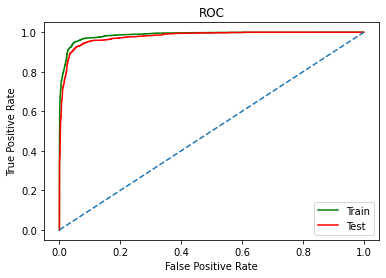

In [55]:
bgcls_train_fpr, bgcls_train_tpr,_=roc_curve(trains_labels,bgcls.predict_proba(X_trains)[:,1])
bgcls_test_fpr, bgcls_test_tpr,_=roc_curve(tests_labels,bgcls.predict_proba(X_tests)[:,1])
plt.plot(bgcls_train_fpr,bgcls_train_tpr,color='green',label='Train')
plt.plot(bgcls_test_fpr,bgcls_test_tpr,color='red',label='Test')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC')
bgcls_train_auc=roc_auc_score(trains_labels,bgcls.predict(X_trains))
bgcls_test_auc=roc_auc_score(tests_labels,bgcls.predict(X_tests))
print('Area under Curve Train is', bgcls_train_auc)
print('Area under Curve Test is', bgcls_test_auc)

## RF

{'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 300}
Confusion Matrix


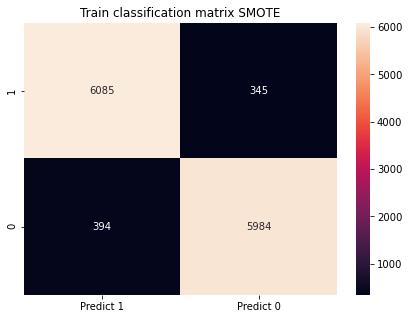

In [63]:
param_grid = {
    'max_depth': [10],
    'max_features': [6],
    'min_samples_leaf': [10],
    'min_samples_split': [50],
    'n_estimators': [300]
}

rfcl = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rfcl, param_grid = param_grid, cv = 5,n_jobs=-1)
grid_search.fit(X_trains, trains_labels)
print(grid_search.best_params_)
ytrains_predict=grid_search.predict(X_trains)
ys_predict = grid_search.predict(X_tests)
#coef_df = pd.DataFrame(grid_search.feature_importances_, columns= X_train.columns)
#coef_df['intercept'] = grid_search.intercept_
print("Confusion Matrix")
cm=metrics.confusion_matrix(trains_labels, ytrains_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Train classification matrix SMOTE')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

In [82]:
rf_metrics=classification_report(trains_labels, ytrains_predict,output_dict=True)
df=pd.DataFrame(rf_metrics).transpose()
rfs_train_precision=round(df.loc["1"][0],2)
rfs_train_recall=round(df.loc["1"][1],2)
rfs_train_f1=round(df.loc["1"][2],2)
print ('rf_smote_train_precision ',rfs_train_precision)
print ('rf_smote_train_recall ',rfs_train_recall)
print ('rf_smote_train_f1 ',rfs_train_f1)
print('accuracy',grid_search.score(X_trains, trains_labels))

rf_smote_train_precision  0.94
rf_smote_train_recall  0.95
rf_smote_train_f1  0.94
accuracy 0.9430824484697065


In [83]:
rf_metrics=classification_report(tests_labels, ys_predict,output_dict=True)
df=pd.DataFrame(rf_metrics).transpose()
rfs_test_precision=round(df.loc["1"][0],2)
rfs_test_recall=round(df.loc["1"][1],2)
rfs_test_f1=round(df.loc["1"][2],2)
print ('rf_smote_test_precision ',rfs_test_precision)
print ('rf_smote_test_recall ',rfs_test_recall)
print ('rf_smote_test_f1 ',rfs_test_f1)
print('accuracy',grid_search.score(X_tests, tests_labels))

rf_smote_test_precision  0.93
rf_smote_test_recall  0.93
rf_smote_test_f1  0.93
accuracy 0.9282331511839709


Area under Curve Train is 0.9437734299523975
Area under Curve Test is 0.9283795454657066


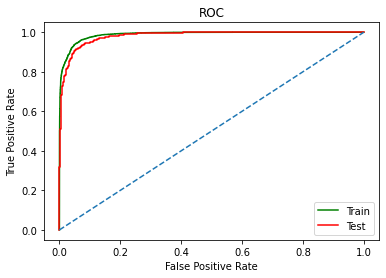

In [59]:
rfs_train_fpr, rfs_train_tpr,_=roc_curve(trains_labels,grid_search.predict_proba(X_trains)[:,1])
rfs_test_fpr, rfs_test_tpr,_=roc_curve(tests_labels,grid_search.predict_proba(X_tests)[:,1])
plt.plot(rfs_train_fpr,rfs_train_tpr,color='green',label='Train')
plt.plot(rfs_test_fpr,rfs_test_tpr,color='red',label='Test')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC')
rfs_train_auc=roc_auc_score(trains_labels,grid_search.predict(X_trains))
rfs_test_auc=roc_auc_score(tests_labels,grid_search.predict(X_tests))
print('Area under Curve Train is', rfs_train_auc)
print('Area under Curve Test is', rfs_test_auc)

[0.37953259 0.0470589  0.01892898 0.01080656 0.00536568 0.0068446
 0.02783477 0.06820722 0.0585465  0.01066619 0.03754986 0.20447998
 0.01662317 0.00901146 0.05091501 0.02751327 0.02011527]


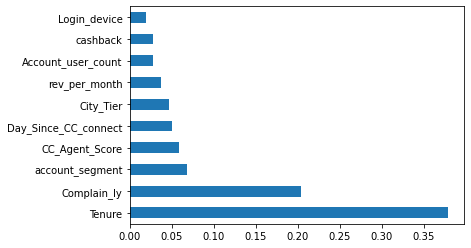

In [71]:
from xgboost import plot_importance
print(grid_search.best_estimator_.feature_importances_)
feat_importances = pd.Series(grid_search.best_estimator_.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')


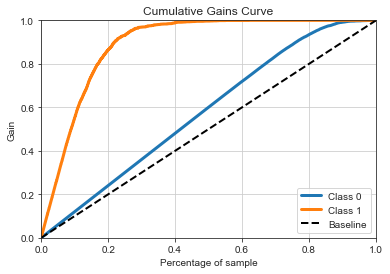

In [102]:
predictions = grid_search.best_estimator_.predict_proba(X)

skplt.metrics.plot_cumulative_gain(y_true=y, y_probas=predictions)
ax.set_xlabel('Percentage of sample', fontsize=20)
ax.set_ylabel('Gain', fontsize=20)
plt.show()

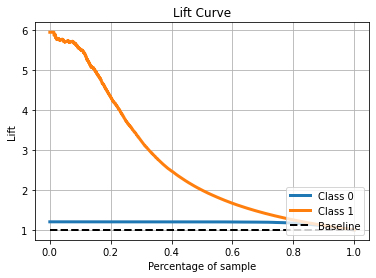

In [75]:

skplt.metrics.plot_lift_curve(y_true=y, y_probas=predictions)

plt.show()

In [ ]:
(9149+1852)*0.85 =   --> responses after marketing to the 20% leads the model ranked as most likely to respond. 
The expected baseline number without using the model would only be 20% of the (9149+1852) actual responders, or (9149+1852) X 0.2 = 237.4 responses for marketing to those 20% leads.

## XGB

Confusion Matrix


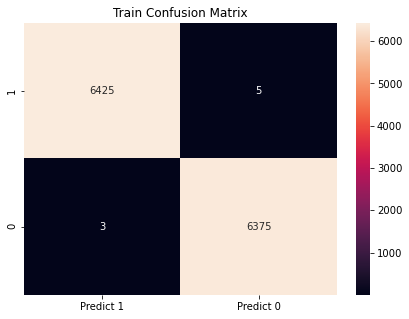

In [32]:
models = xgb.XGBClassifier()
models.fit(X_trains, trains_labels)
#print(grid_search.best_params_)
ytrains_predict=models.predict(X_trains)
ys_predict = models.predict(X_tests)
coef_df = pd.DataFrame(models.feature_importances_, columns = ["Imp"], index = X_trains.columns)
#coef_df['intercept'] = grid_search.intercept_
print("Confusion Matrix")
cm=metrics.confusion_matrix(trains_labels, ytrains_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
plt.title('Train Confusion Matrix')
sns.heatmap(df_cm, annot=True,fmt='0.5g')

In [33]:
xgb_metrics=classification_report(trains_labels, ytrains_predict,output_dict=True)
df=pd.DataFrame(xgb_metrics).transpose()
xgbs_train_precision=round(df.loc["1"][0],2)
xgbs_train_recall=round(df.loc["1"][1],2)
xgbs_train_f1=round(df.loc["1"][2],2)
print ('xgb_smote_train_precision ',xgbs_train_precision)
print ('xgb_smote_train_recall ',xgbs_train_recall)
print ('xgb_smote_train_f1 ',xgbs_train_f1)
print('accuracy',models.score(X_trains, trains_labels))

xgb_smote_train_precision  1.0
xgb_smote_train_recall  1.0
xgb_smote_train_f1  1.0
accuracy 0.9993753903810119


In [34]:
xgb_metrics=classification_report(tests_labels, ys_predict,output_dict=True)
df=pd.DataFrame(xgb_metrics).transpose()
xgbs_test_precision=round(df.loc["1"][0],2)
xgbs_test_recall=round(df.loc["1"][1],2)
xgbs_test_f1=round(df.loc["1"][2],2)
print ('xgb_smote_test_precision ',xgbs_test_precision)
print ('xgb_smote_test_recall ',xgbs_test_recall)
print ('xgb_smote_test_f1 ',xgbs_test_f1)
print('accuracy',models.score(X_tests, tests_labels))

xgb_smote_test_precision  0.98
xgb_smote_test_recall  0.98
xgb_smote_test_f1  0.98
accuracy 0.9845173041894353


Area under Curve Train is 0.9993760140685785
Area under Curve Test is 0.9845141896134623


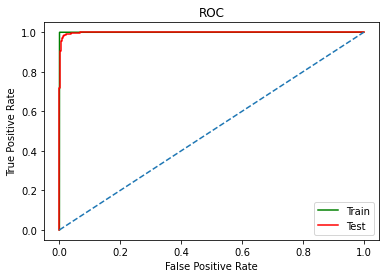

In [35]:
xgbs_train_fpr, xgbs_train_tpr,_=roc_curve(trains_labels,models.predict_proba(X_trains)[:,1])
xgbs_test_fpr, xgbs_test_tpr,_=roc_curve(tests_labels,models.predict_proba(X_tests)[:,1])
plt.plot(xgbs_train_fpr,xgbs_train_tpr,color='green',label='Train')
plt.plot(xgbs_test_fpr,xgbs_test_tpr,color='red',label='Test')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC')
xgbs_train_auc=roc_auc_score(trains_labels,models.predict(X_trains))
xgbs_test_auc=roc_auc_score(tests_labels,models.predict(X_tests))
print('Area under Curve Train is', xgbs_train_auc)
print('Area under Curve Test is', xgbs_test_auc)

In [36]:
#ROC CURVE FOR ALL ENSEMBLE MODELS WITHOUT SMOTE TRAIN

NameError: name 'rf_train_fpr' is not defined

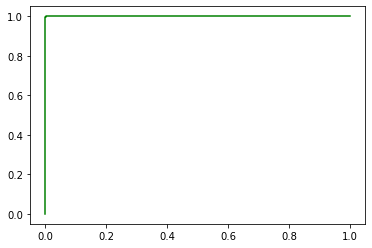

In [37]:
plt.plot(xgb_train_fpr,xgb_train_tpr,color='green',label='XGB')
plt.plot(rf_train_fpr,rf_train_tpr,color='red',label='RF')
plt.plot(bgcl_train_fpr,bgcl_train_tpr,color='blue',label='BGCL')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Train ROC')

NameError: name 'rf_test_fpr' is not defined

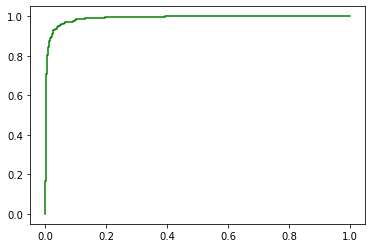

In [38]:
plt.plot(xgb_test_fpr,xgb_test_tpr,color='green',label='XGB')
plt.plot(rf_test_fpr,rf_test_tpr,color='red',label='RF')
plt.plot(bgcl_test_fpr,bgcl_test_tpr,color='blue',label='BGCL')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Test ROC')

Text(0.5, 1.0, 'Train SMOTE ROC')

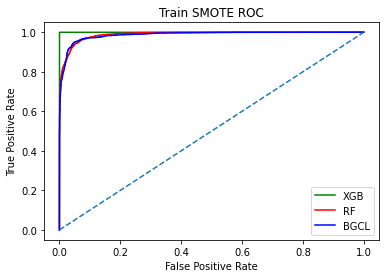

In [95]:
plt.plot(xgbs_train_fpr,xgbs_train_tpr,color='green',label='XGB')
plt.plot(rfs_train_fpr,rfs_train_tpr,color='red',label='RF')
plt.plot(bgcls_train_fpr,bgcls_train_tpr,color='blue',label='BGCL')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Train SMOTE ROC')

Text(0.5, 1.0, 'Test SMOTE ROC')

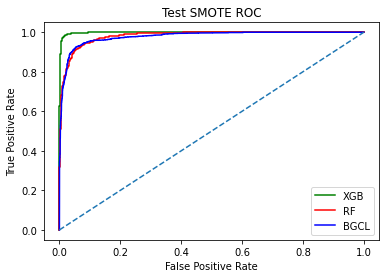

In [96]:
plt.plot(xgbs_test_fpr,xgbs_test_tpr,color='green',label='XGB')
plt.plot(rfs_test_fpr,rfs_test_tpr,color='red',label='RF')
plt.plot(bgcls_test_fpr,bgcls_test_tpr,color='blue',label='BGCL')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Test SMOTE ROC')

## Gain & Lift Analysis

In [42]:
!python -m pip install Scikit-learn

In [43]:
!pip install scikit-plot

In [44]:
import scikitplot as skplt

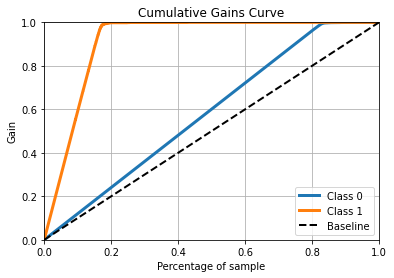

In [77]:
predictions = models.predict_proba(X)

skplt.metrics.plot_cumulative_gain(y_true=y, y_probas=predictions)

plt.show()

In [47]:
dth['Churn'].value_counts()

0    9149
1    1852
Name: Churn, dtype: int64

In [49]:
(9149+1852)*0.4

4400.400000000001

(9149+1852)*0.5 = 5500 --> responses after marketing to the 40% leads the model ranked as most likely to respond. 
The expected baseline number without using the model would only be 40% of the (9149+1852) actual responders, or (9149+1852) X 0.2 = 237.4 responses for marketing to those 5,000 leads.

In [ ]:
when select 40% to ppl , response is 45% whereas for baseline it is 40%
so total improvement is 45/40  == 1.125

In [50]:
45/40


1.125

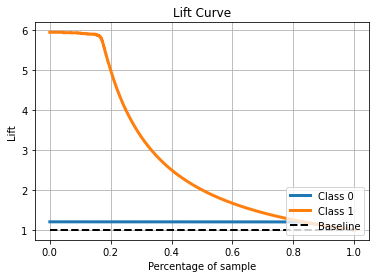

In [78]:
skplt.metrics.plot_lift_curve(y_true=y, y_probas=predictions)

plt.show()

[0.19510162 0.06906649 0.01812776 0.02363543 0.02193314 0.02773148
 0.04960028 0.0613986  0.04797778 0.03027838 0.04925018 0.2803473
 0.01841676 0.01905834 0.02899718 0.01549947 0.04357986]


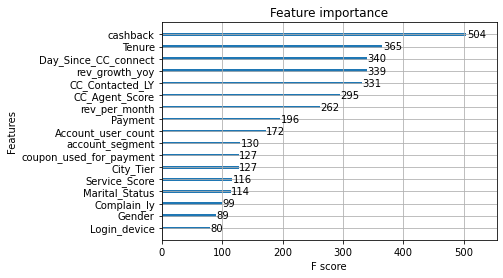

In [59]:
from xgboost import plot_importance
print(models.feature_importances_)
plot_importance(models)
plt.show()